# Gene-level analysis of HC association

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import seaborn as sns
import anndata
import warnings 
import scipy.stats
from collections import Counter
import os

warnings.filterwarnings('ignore')
#os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/ImageSpot/')
#import scvi_wrapper as s_w
import statsmodels.api as sm

Global seed set to 0


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

sc.logging.print_header()
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi = 200, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf',fontsize=5)
plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams['pdf.fonttype'] = 42
# sns.set_palette('colorblind')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [4]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, format = 'pdf',fontsize=5)

# Gene expression analysis

In [209]:
adata_scvi = sc.read_h5ad('/nfs/team205/ny1/ThymusSpatialAtlas/figure6/HTSA_adata_vis_scvi_corrected_v3.h5ad')

In [210]:
adata_scvi = adata_scvi[adata_scvi.obs['tot_cell_abundance']>30,:].copy()
adata_scvi = adata_scvi[adata_scvi.obs['n_genes_by_counts']>1500,:].copy()
adata_scvi = adata_scvi[adata_scvi.obs['Age_group']!='fetal',:].copy()
adata_scvi

AnnData object with n_obs × n_vars = 18937 × 20733
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequen

In [13]:
adata_scvi = adata_scvi[((adata_scvi.obs['annotations_level_1']!="fat") & (adata_scvi.obs['annotations_level_0']!="Artifacts")),:].copy()

## remove meduala less lobules 
adata_scvi.obs['full_lobule'] = 0
for s in adata_scvi.obs['SampleID'].cat.categories.tolist():
    sample = adata_scvi[adata_scvi.obs['SampleID'].isin([s])]
    for l in sample.obs['annotations_lobules_0'].cat.categories:
        lobule = sample.obs['annotations_lobules_0'] == l
        med = np.where(sample.obs['annotations_level_0'][lobule] == 'Medulla')[0]
        cortex = np.where(sample.obs['annotations_level_0'][lobule] == 'Cortex')[0]
        if (cortex.size>=5) & (med.size>=5):
            adata_scvi.obs['full_lobule'][lobule.iloc[np.where(lobule)].index] = 1
adata_scvi.obs['full_lobule'] = adata_scvi.obs['full_lobule'].astype('category')
adata_scvi.obs['full_lobule'].value_counts()
adata_scvi = adata_scvi[adata_scvi.obs['full_lobule']==1] # remove spots that don't have either medullar or cortical data
adata_scvi = adata_scvi.copy()

1    18554
Name: full_lobule, dtype: int64

In [9]:
# version 3 hybrid wighted mean 
def mean_space_gene(adata_vis,anno,threshold = 0.5,minspots=20):
    space_map = {}
    obs_ind = np.where(adata_vis.obs.columns == anno)[0]
    for c in adata_vis.var_names:
        temp = adata_vis.X[:,adata_vis.var_names==c]
        points_above = np.where(temp>threshold)[0]
        if len(points_above)>minspots:
                spot_counts = np.squeeze(np.array(temp)[points_above])      
                axis_value = np.squeeze(np.array(adata_vis.obs.iloc[points_above,obs_ind]))
                space_map[c] = (np.dot(spot_counts,axis_value)/np.sum(spot_counts))
    return space_map

In [15]:
%%time
space_map_cma = mean_space_gene(adata_scvi_filt,'cma_v2',threshold=0.2,minspots=20)
space_map_hc = mean_space_gene(adata_scvi_filt,'L2_dist_annotations_level_1_HS',threshold=0.2,minspots=20)

CPU times: user 21min 51s, sys: 1min 25s, total: 23min 16s
Wall time: 2min 20s


In [16]:
space_map_cma_filt = {}
for i in space_map_cma:
    if space_map_cma[i]!=None:
        if space_map_cma[i]>0.55:
            space_map_cma_filt[i] = space_map_cma[i] # remove cells that are not medullar centered  
print(len(space_map_cma_filt))

851


In [17]:
space_map_hc_filt = {}
for i in space_map_cma_filt:
#     space_map_hc[i] = space_map_hc[i]*2 # correct back to linear and micron distance ppm=0.5 hence the 2 
    if space_map_hc[i]<350/2:
        if space_map_hc[i]!=None:
                space_map_hc_filt[i] = space_map_hc[i]*2 # space_map_hc[i]*2 # correct back to linear and micron distance ppm=0.5 hence the 2 
print(len(space_map_hc_filt))

851


In [49]:
# generate genes that are cadidates for marker genes 
keys_list = np.array(list(space_map_hc_filt.keys()))
np.save('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/Candidate_broad_HC_genes.npy', keys_list)


In [14]:
# read back marker genes 
marker_dict_1 = np.load('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/marker_genes_max_1.npy',allow_pickle=True).item()
marker_dict_2 = np.load('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/marker_genes_max_2.npy',allow_pickle=True).item()

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [52]:
df = pd.DataFrame.from_dict({'space_map_cma': space_map_cma_filt, 'space_map_hc': space_map_hc_filt}, orient='index').T.dropna()

space_map_cma  space_map_hc  B-memory_unique  DC1_unique  \
AGRN             0.637555    108.020218            False       False   
AL390719.2       0.620003     80.047811            False       False   
TNFRSF18         0.641657    132.434995            False       False   
TNFRSF4          0.570152    163.429201            False       False   
TP73             0.640746    128.983331            False       False   
...                   ...           ...              ...         ...   
SLITRK2          0.652333     33.658415            False       False   
GABRE            0.622722    130.940622            False       False   
PNMA3            0.623894    157.701285            False       False   
CLIC2            0.599161    160.155270            False       False   
AC145212.1       0.551247     79.979523            False       False   

            Macrophage-APOC2_unique  TEC-myo_unique  T_CD8αα(II)_unique  \
AGRN                          False           False               False   
AL390719.2                    False           False               False   
TNFRSF18                      False           False               False   
TNFRSF4                       False           False               False   
TP73                          False           False               False   
...                             ...             ...                 ...   
SLITRK2                       False           False               False   
GABRE                         False           False               False   
PNMA3                         False           False               False   
CLIC2                         False           False               False   
AC145212.1                    False           False               False   

            T_NK_unique  T_Treg_recirc_unique  aDC3_unique  mTECII_unique  \
AGRN              False                 False        False          False   
AL390719.2        False                 False        False          False   
TNFRSF18          False                  True        False          False   
TNFRSF4           False                 False        False          False   
TP73              False                 False        False          False   
...                 ...                   ...          ...            ...   
SLITRK2           False                 False        False          False   
GABRE             False                 False        False          False   
PNMA3             False                 False        False          False   
CLIC2             False                 False        False          False   
AC145212.1        False                 False        False          False   

            mTECIII_unique  pDC_unique  
AGRN                 False       False  
AL390719.2           False       False  
TNFRSF18             False       False  
TNFRSF4              False       False  
TP73                 False       False  
...                    ...         ...  
SLITRK2              False       False  
GABRE                False       False  
PNMA3                False       False  
CLIC2                False       False  
AC145212.1           False       False  

[851 rows x 13 columns]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 200.0)

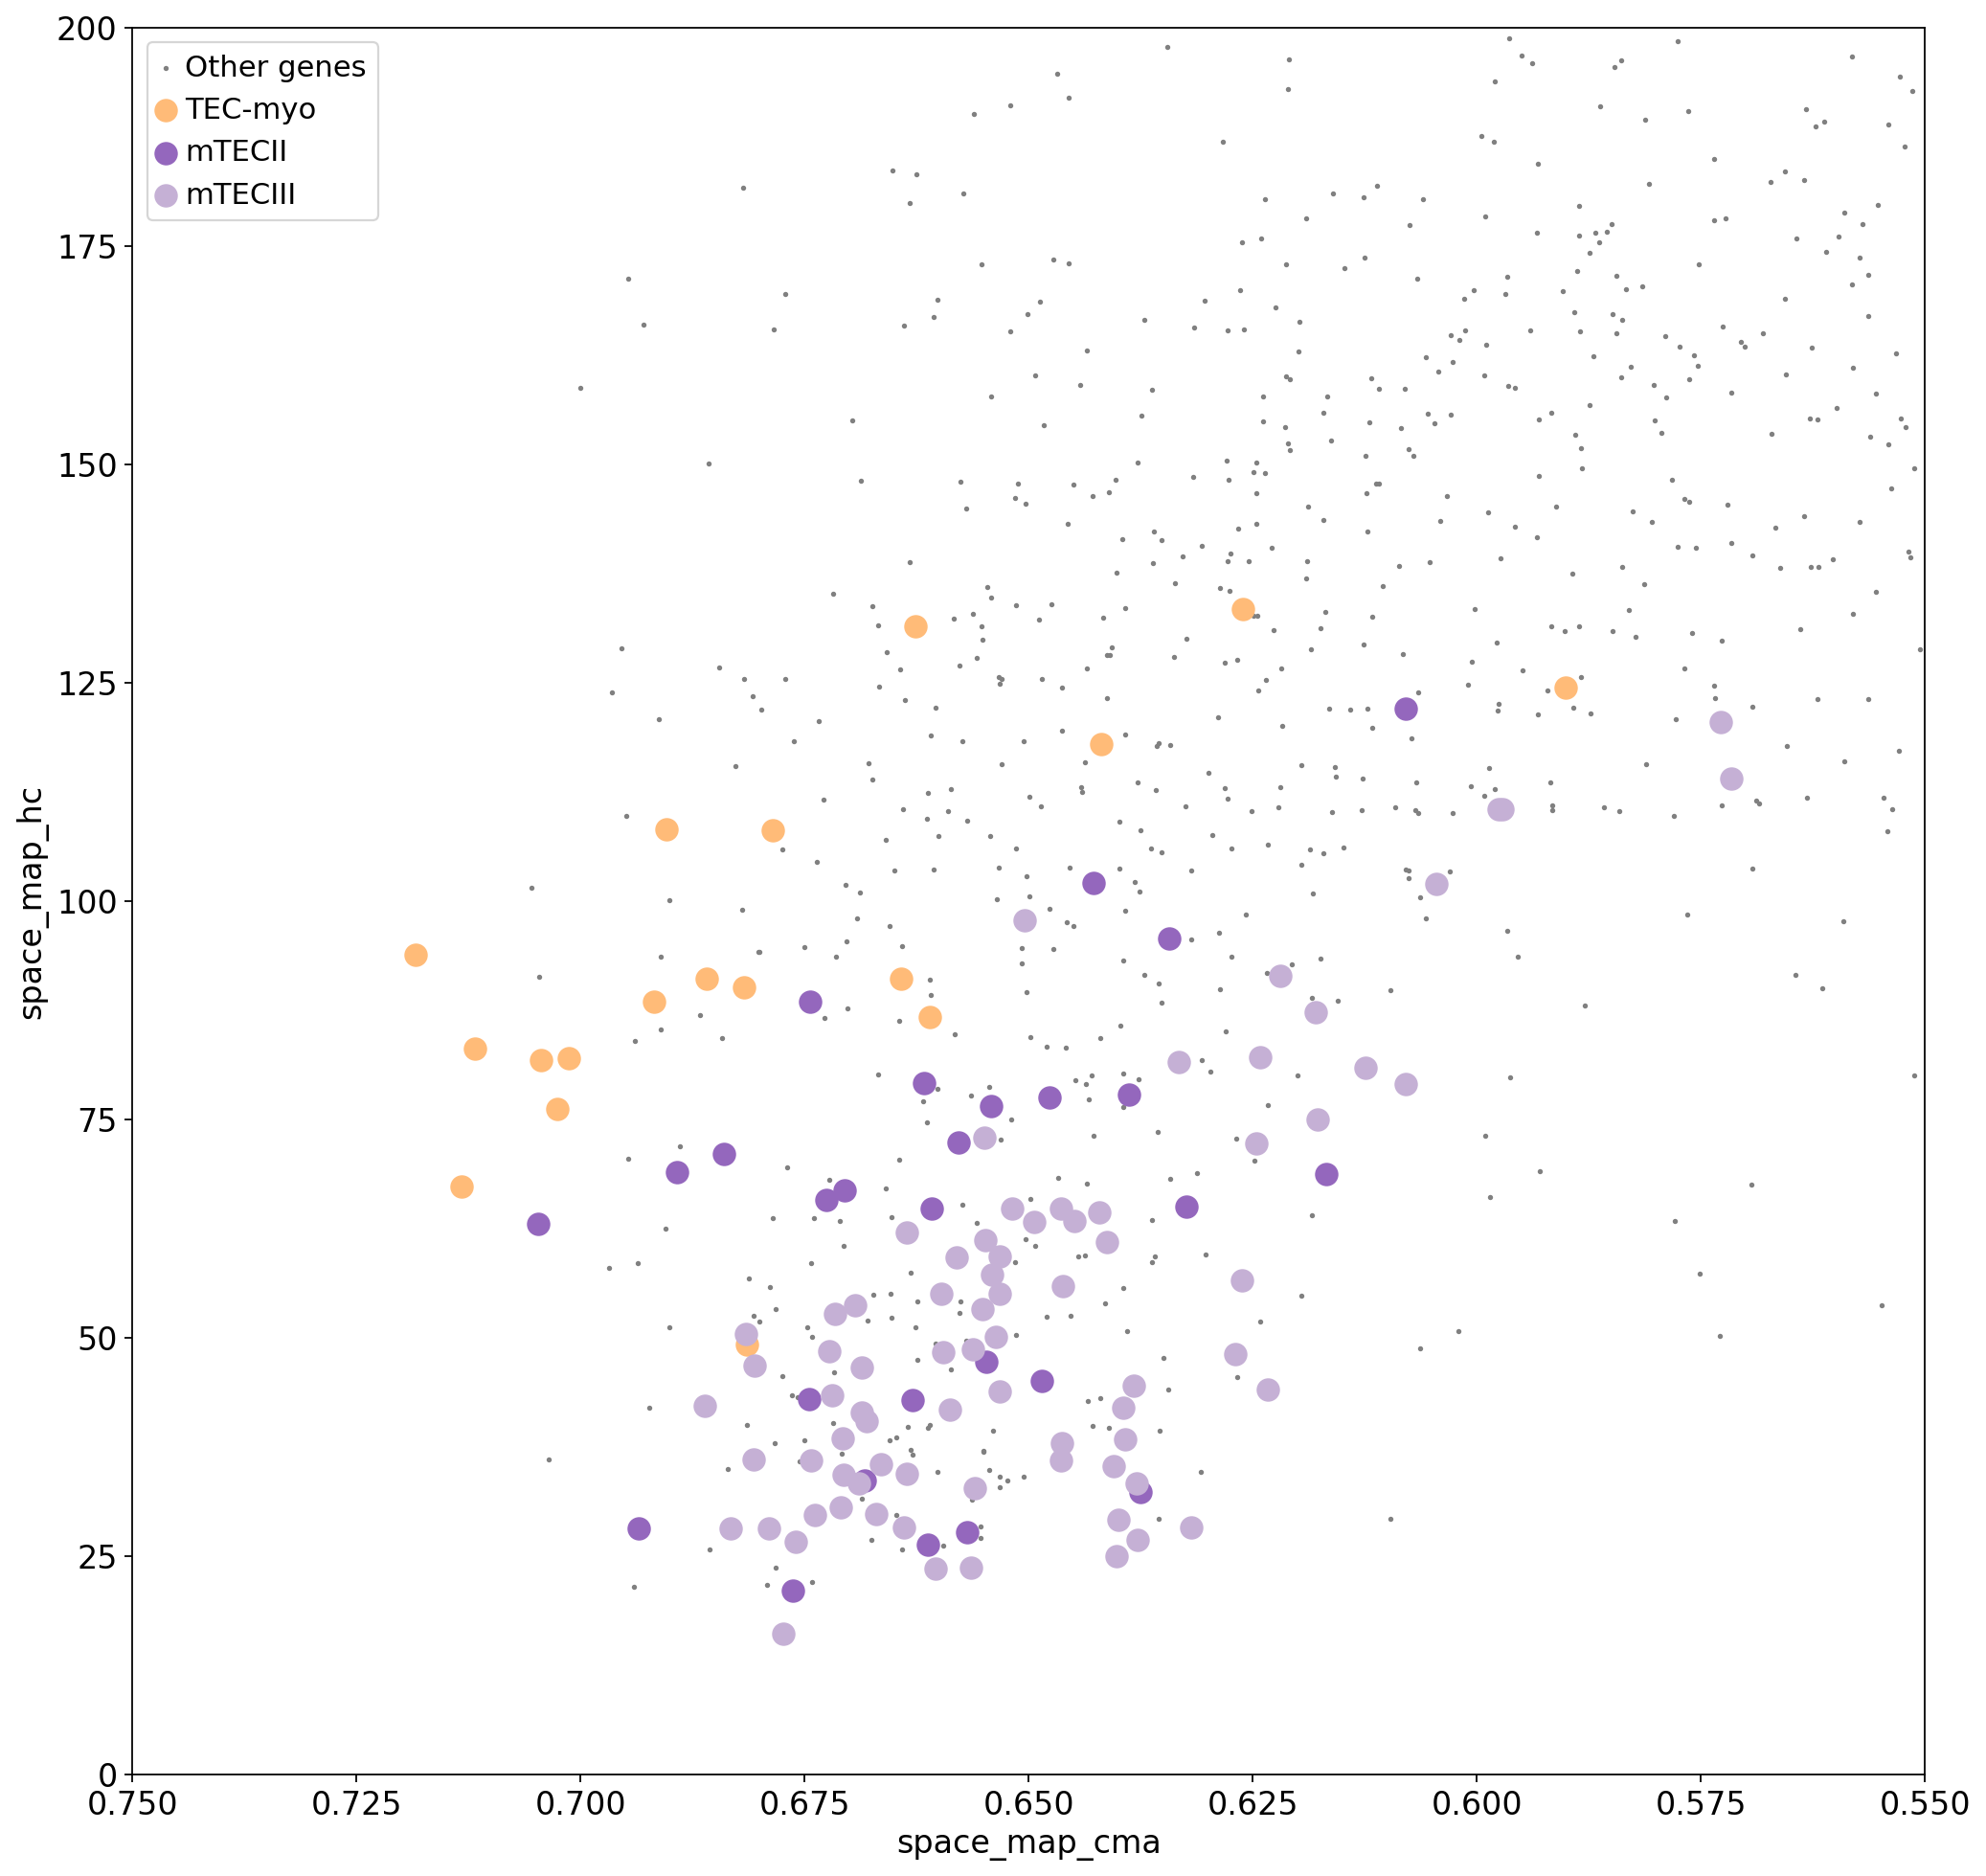

In [53]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])
df

colors = sns.color_palette('tab20', 20)
# cmap = ListedColormap(colors)

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
for idx, key in enumerate(marker_dict_1.keys()):
    if 'TEC' in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=colors[idx], label=key, s=100)

plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 200)

# plt.savefig('figures/HC_CMA_association_genes_Visium_scvi_cma0.55.pdf')
plt.show()


<Figure size 1200x1200 with 0 Axes>

Text(0.6375546181139611, 108.0202176360924, 'AGRN')

Text(0.6200025545670055, 80.04781050494495, 'AL390719.2')

Text(0.6416567628706458, 132.43499466803505, 'TNFRSF18')

Text(0.5701517797832202, 163.42920137538434, 'TNFRSF4')

Text(0.6407455919279933, 128.98333125435474, 'TP73')

Text(0.6940005176336566, 21.400501938980536, 'HES2')

Text(0.6570183049159207, 49.59420171533701, 'ESPN')

Text(0.6667395590288033, 124.47125151651159, 'TNFRSF9')

Text(0.6084675799174302, 154.08780228060783, 'ERRFI1')

Text(0.6185691793015522, 105.8709471213191, 'GPR157')

Text(0.6184493055130361, 88.9171341697847, 'SLC25A33')

Text(0.601417377116029, 168.9275627699582, 'FBXO6')

Text(0.5561234749235406, 153.0941681839465, 'PDPN')

Text(0.6110661960182049, 215.2458830733114, 'TMEM51')

Text(0.5728818758808427, 50.142975767428204, 'EPHA2')

Text(0.584079984006869, 110.21680880884598, 'ARHGEF19')

Text(0.577599301241561, 198.4363062286376, 'BX284668.5')

Text(0.6530292033398091, 115.68533721780274, 'PADI2')

Text(0.6190770411762113, 178.17927965217987, 'ARHGEF10L')

Text(0.6065338978898833, 123.86169862646541, 'TMCO4')

Text(0.6463690048831191, 64.74391608434071, 'PLA2G2F')

Text(0.6586755586623942, 46.316072812310495, 'CAMK2N1')

Text(0.6543886580127042, 34.804323946284185, 'WNT4')

Text(0.5631336842855812, 283.82049236061437, 'TCEA3')

Text(0.636391956162737, 105.92776371073766, 'MDS2')

Text(0.593833451336429, 195.8844491690854, 'CNR2')

Text(0.6741381277125913, 21.990021305175055, 'CRYBG2')

Text(0.6153184393442421, 208.38812039860113, 'ZNF683')

Text(0.558974278998856, 115.98028090046022, 'MAP3K6')

Text(0.6609238295508955, 118.86649051860839, 'MECR')

Text(0.6630004393569122, 36.60430223204846, 'PTPRU')

Text(0.6710149192419702, 63.31778634513536, 'TMEM54')

Text(0.6791475750966001, 21.60866678375269, 'SH3D21')

Text(0.5916963968043418, 131.4718213232461, 'ZC3H12A')

Text(0.6436752393337593, 115.83627219144167, 'FHL3')

Text(0.6775190041004694, 105.83725625222849, 'MYCL')

Text(0.6324324178027518, 130.0497108065014, 'COL9A2')

Text(0.6668239332580744, 80.11543506415698, 'CITED4')

Text(0.5692464670846642, 139.58845852619044, 'B4GALT2')

Text(0.6189387515667445, 138.87244312688466, 'CCDC163')

Text(0.6836008766696493, 34.89479103620335, 'TSPAN1')

Text(0.6635590647740764, 61.960605485237494, 'CYP4B1')

Text(0.6716514212530432, 52.70332947551867, 'PDZK1IP1')

Text(0.6079033293712858, 103.53792188936953, 'TACSTD2')

Text(0.6785721417130035, 63.6189113825493, 'FGGY')

Text(0.5536617560422352, 110.48755967000292, 'CACHD1')

Text(0.5767962868455191, 126.56525157809216, 'PDE4B')

Text(0.6212525989848108, 160.0873944296418, 'MCOLN2')

Text(0.5830742465106576, 133.31419481108904, 'GBP3')

Text(0.6278459000556863, 165.33350350039214, 'GBP4')

Text(0.6632240929610117, 179.83532900186523, 'GBP5')

Text(0.5799960458341703, 231.52950569434495, 'LRRC8C')

Text(0.6938830559041679, 83.92848397763869, 'EVI5')

Text(0.6429012561804771, 39.84893902900437, 'F3')

Text(0.6307309616373395, 140.67171689716088, 'CLCC1')

Text(0.6353498955397837, 39.26662128095712, 'CELSR2')

Text(0.559872650944048, 156.3893025383401, 'CD58')

Text(0.640267359502745, 148.24515438073325, 'LINC02591')

Text(0.6377646278581994, 79.56718569261722, 'NBPF20')

Text(0.6307626337454286, 34.63673589182477, 'ANKRD35')

Text(0.5511465744674227, 149.56395598896137, 'NBPF14')

Text(0.5932930229575835, 141.63453097420546, 'AC245297.3')

Text(0.6648025102093444, 38.582505370024776, 'BNIPL')

Text(0.635449877164029, 29.238063325695883, 'TUFT1')

Text(0.6232905232413641, 44.077655053705215, 'RPTN')

Text(0.6532302465045967, 55.004391397188456, 'FLG')

Text(0.6639325447963514, 28.206270759687698, 'FLG2')

Text(0.6612159221208153, 26.236789016046703, 'LCE3D')

Text(0.6420923883561135, 64.27816678546397, 'IVL')

Text(0.6709647399503224, 30.491119633931714, 'SPRR3')

Text(0.6246258166705531, 72.19365579653791, 'SPRR1B')

Text(0.6760137598533343, 26.57864785572218, 'SPRR2D')

Text(0.6669563367165356, 29.806642885666864, 'SPRR2E')

Text(0.6744859742061121, 42.94183211874238, 'SPRR2G')

Text(0.6177662381957267, 74.9959135862545, 'LOR')

Text(0.6691552132249887, 41.85274702948114, 'PGLYRP4')

Text(0.6123982177843371, 80.81847282162907, 'S100A7')

Text(0.5980134328282465, 112.77354139375602, 'S100A2')

Text(0.608082010189684, 158.57268723326754, 'IL6R')

Text(0.5639531813113984, 131.11179782219563, 'ZBTB7B')

Text(0.676456767581728, 43.42400650357429, 'MUC1')

Text(0.6362175234569549, 63.406563381955955, 'RAB25')

Text(0.6197518308350091, 166.29360279004885, 'SEMA4A')

Text(0.6435853198674768, 78.9865078491187, 'CRABP2')

Text(0.6316949404475869, 148.5053437478801, 'FCRL5')

Text(0.6472424057878542, 173.4550659537029, 'FCRL3')

Text(0.644788175709025, 200.5117120041106, 'FCRL2')

Text(0.5514389793939619, 192.72710978826248, 'MNDA')

Text(0.6641511617758564, 25.69033292798744, 'VSIG8')

Text(0.6806367203292469, 52.460696252141645, 'IGSF9')

Text(0.558171373212329, 196.69616992592483, 'SLAMF7')

Text(0.6463269062941077, 37.88013669128183, 'NECTIN4')

Text(0.6866177010650608, 86.85579169892158, 'FCRLA')

Text(0.5598508468017425, 218.50018842217767, 'OLFML2B')

Text(0.6497766453465408, 97.5551762527284, 'UAP1')

Text(0.5965394309908356, 158.90184105663351, 'TBX19')

Text(0.588588365136996, 179.52654794837446, 'XCL1')

Text(0.6040941555554405, 143.48752622734128, 'FMO1')

Text(0.6086486905009543, 138.34859652870387, 'SOAT1')

Text(0.6750280196917932, 38.25935765239283, 'INAVA')

Text(0.6817775522411504, 90.07065893838092, 'TNNT2')

Text(0.6375743997644673, 101.06504352011224, 'LAD1')

Text(0.6859524972275348, 91.01892759855409, 'TNNI1')

Text(0.6160323379881351, 180.98608070013552, 'NAV1')

Text(0.6673733066916305, 54.8808641902234, 'ELF3')

Text(0.7184081172053411, 93.81774457747046, 'MYBPH')

Text(0.57271399146708, 129.80499492768575, 'CHI3L1')

Text(0.5890067544781676, 153.3417681163988, 'CHIT1')

Text(0.5722677983564988, 178.1539640017096, 'FMOD')

Text(0.6190588736996273, 136.89250789839295, 'TMCC2')

Text(0.6530116046305416, 125.41191145801426, 'NUAK2')

Text(0.6057174209709022, 97.97983180913306, 'CDK18')

Text(0.6315611459526556, 165.65239378653737, 'RAB7B')

Text(0.6686426018723327, 46.54006187282647, 'PIGR')

Text(0.5621486595048967, 188.62195135164305, 'PLXNA2')

Text(0.6349120735779956, 47.70304578303713, 'ATF3')

Text(0.5849556817313658, 177.44739637797207, 'BATF3')

Text(0.6624679716576511, 183.15476055919967, 'HLX')

Text(0.6237979051666276, 154.89756082973994, 'DUSP10')

Text(0.6743201873298054, 58.50714128758333, 'SUSD4')

Text(0.7012512525468032, 81.94460176684274, 'ACTA1')

Text(0.6600556464589612, 107.45499281117853, 'C1orf198')

Text(0.598754359330039, 144.4398064786395, 'GPR137B')

Text(0.6696691128691742, 154.99940023332246, 'ACTN2')

Text(0.5554675337511998, 158.0472818791924, 'CHRM3-AS2')

Text(0.6771727035133522, 125.3672727957611, 'CMPK2')

Text(0.6410549110402544, 146.784788309086, 'RSAD2')

Text(0.596851899908626, 169.41710854905327, 'ASAP2')

Text(0.6686544650903735, 31.511281818975952, 'GRHL1')

Text(0.6574342392266979, 65.15339964579735, 'LRATD1')

Text(0.6119648791083139, 154.75348638842271, 'FAM49A')

Text(0.6504890744881666, 97.80977707251525, 'SDC1')

Text(0.6354465018887332, 118.0810720142588, 'TTC27')

Text(0.684219536947238, 84.25111748500588, 'LTBP1')

Text(0.6533321271831197, 125.61475446758116, 'RASGRP3')

Text(0.6520885497579616, 191.04990658827253, 'QPCT')

Text(0.6716626937511747, 46.01080494312067, 'LGALSL')

Text(0.624115971277731, 51.82992779382831, 'ASPRV1')

Text(0.6075796380312237, 103.46961153415508, 'RTKN')

Text(0.6520016800827871, 165.19041553358852, 'GNLY')

Text(0.5957054374171656, 158.7676066074907, 'LINC01943')

Text(0.5610203305506757, 174.27389099972245, 'CYTOR')

Text(0.6444245200244351, 59.28604703473873, 'PROM2')

Text(0.5540585563862167, 188.85439526334818, 'CNNM4')

Text(0.5921491971273443, 124.10266152481485, 'SEMA4C')

Text(0.6325369963490745, 110.80800276667419, 'LINC01127')

Text(0.5779054636405155, 63.34733549172355, 'IL1R2')

Text(0.6286879149587192, 135.814984256042, 'IL18R1')

Text(0.5671098962273611, 153.48348534941235, 'POLR1B')

Text(0.6394524142492781, 80.16760506636133, 'IL1RN')

Text(0.670551717874304, 66.82990215969448, 'MARCO')

Text(0.6923791988619924, 41.99117096063525, 'STEAP3')

Text(0.6900862898733817, 100.0941735571362, 'LYPD1')

Text(0.5563661429795872, 123.08020130775851, 'ACVR2A')

Text(0.6342248486030522, 117.87425566869925, 'GPD2')

Text(0.6623726775074065, 54.15123950801976, 'DAPL1')

Text(0.618415858403683, 64.03685791901754, 'GAD1')

Text(0.6395250363744639, 42.115042669184774, 'CHRNA1')

Text(0.627765892749012, 138.90102412701106, 'CTLA4')

Text(0.6206238480879473, 92.74763037456994, 'ADAM23')

Text(0.6642432713410047, 91.08715746736698, 'MYL1')

Text(0.6208907246716598, 159.73853057101473, 'RUFY4')

Text(0.6601406419304329, 78.40552205978491, 'EPHA4')

Text(0.6248064095918933, 70.27393132720282, 'SGPP2')

Text(0.6658602012463016, 128.4055226156495, 'SP140')

Text(0.6401815274733021, 137.57090759682646, 'RAMP1')

Text(0.6479805417974016, 83.23160656130219, 'HES6')

Text(0.669345964981966, 53.64276530672167, 'MAB21L4')

Text(0.6447876284379218, 79.46708778184885, 'FARP2')

Text(0.6360422725706589, 142.25159510088392, 'SUMF1')

Text(0.6560478801582603, 32.68476589913831, 'TMEM40')

Text(0.5667366821894367, 142.76364439069636, 'NR1D2')

Text(0.6164517518604301, 122.0284170073418, 'ZNF621')

Text(0.6629979334468769, 42.84611239425876, 'CCK')

Text(0.6105584095829942, 204.18222448951238, 'XCR1')

Text(0.5619624893748006, 155.1541691145827, 'CCRL2')

Text(0.5505572038023977, 128.7892959731778, 'ALS2CL')

Text(0.6667665546929281, 131.53652088342855, 'CISH')

Text(0.6235148704352349, 125.28577578430802, 'ACY1')

Text(0.7044007662854525, 81.72516123968316, 'TNNC1')

Text(0.5782506534005514, 148.2198832023007, 'PRKCD')

Text(0.6318859177531666, 103.51000467728598, 'WNT5A')

Text(0.6605971559292716, 103.53250976189756, 'ABHD6')

Text(0.6832673895087941, 28.08083208916675, 'FAM3D')

Text(0.6419763189213559, 84.26864741160307, 'FEZF2')

Text(0.6371462559080195, 166.52969835118768, 'LRIG1')

Text(0.6459060683577181, 83.12494579544637, 'TMEM45A')

Text(0.5858430161381004, 110.6997877848137, 'NFKBIZ')

Text(0.6493001012458959, 160.1855174491913, 'TIGIT')

Text(0.6392080445956302, 38.318555005935394, 'UPK1B')

Text(0.6434872926839429, 162.97850791392418, 'CD86')

Text(0.6212310827365943, 172.81566778854727, 'ALDH1L1')

Text(0.6295461760705722, 107.54669642995746, 'RBP1')

Text(0.6266006689328315, 142.56412149088248, 'GPR87')

Text(0.6457522593248014, 97.55102916923977, 'P2RY1')

Text(0.6577232678131792, 52.80753685548079, 'PLD1')

Text(0.6935236132693081, 28.131593143304585, 'SST')

Text(0.6318457037762388, 95.60148877949786, 'TPRG1')

Text(0.5976853348676044, 121.78640328028067, 'CLDN1')

Text(0.6401995035340172, 24.944287534873872, 'MUC4')

Text(0.6063526301862916, 100.37203864876734, 'FGFR3')

Text(0.6412987830963799, 60.87964388449013, 'S100P')

Text(0.6856466283063437, 25.678658921798633, 'PSAPL1')

Text(0.5632678771128218, 190.65902943664804, 'CLNK')

Text(0.6722712154941936, 68.07958731837591, 'LGI2')

Text(0.6266863765778842, 45.465769645380206, 'SLC34A2')

Text(0.6278648493818012, 150.37477720410368, 'TLR10')

Text(0.6757950335847684, 43.19813026093468, 'FAM114A1')

Text(0.599152052403459, 111.96059204804743, 'LIMCH1')

Text(0.6245136745314973, 132.57819303070275, 'PDGFRA')

Text(0.6082214355486146, 128.2205684386102, 'HOPX')

Text(0.6912965341762732, 120.73885653101202, 'SPINK2')

Text(0.6605824597859907, 166.83508770120633, 'STAP1')

Text(0.6507642596514546, 94.62260040341877, 'CSN2')

Text(0.616847371564333, 68.68890885962433, 'FDCSP')

Text(0.690111823942495, 51.14291618395438, 'CXCL6')

Text(0.663952220043659, 90.30391671693431, 'CXCL1')

Text(0.5590382120391884, 211.04891738812861, 'NAAA')

Text(0.5672060812839165, 182.30255769884735, 'CXCL9')

Text(0.6171413277461077, 155.87830079662203, 'CXCL10')

Text(0.6552768895593891, 172.87041363296774, 'CXCL11')

Text(0.66740058474772, 133.67977641484515, 'CXCL13')

Text(0.612871184025808, 110.32541747358324, 'TMEM150C')

Text(0.5614406621189787, 89.99132584544964, 'PTPN13')

Text(0.6245911980132655, 143.1049494681268, 'SPP1')

Text(0.5757764939333262, 162.41446248261963, 'HERC6')

Text(0.6514254421787424, 133.848076665964, 'HERC5')

Text(0.5612811378691915, 189.247738124111, 'GPRIN3')

Text(0.6109467302576121, 158.56214893596567, 'DAPP1')

Text(0.6198909818504181, 162.86489860311033, 'BANK1')

Text(0.5855307749268478, 176.6408683739308, 'TNIP3')

Text(0.6641621227399086, 94.84325614358994, 'FGF2')

Text(0.5837295575997111, 138.26242984408597, 'TMEM154')

Text(0.586568982963429, 230.11122704328807, 'MARCH1')

Text(0.5778020662513527, 120.81420169340421, 'MSMO1')

Text(0.6718331635878404, 40.21631114383067, 'TENM3')

Text(0.5932273555851031, 121.32916759098389, 'ACSL1')

Text(0.5887081709499592, 209.96437236063306, 'SEMA5A')

Text(0.5552515763747572, 179.6310428343179, 'OTULINL')

Text(0.5990870241228778, 178.33294821360425, 'OSMR')

Text(0.6651509984930675, 183.56834998994856, 'GZMK')

Text(0.6502825031915677, 89.52269484291081, 'ELL2')

Text(0.6488742020101463, 132.17345481177344, 'MCC')

Text(0.6557937443313442, 127.79224658933236, 'SEMA6A')

Text(0.6644686973118096, 70.33069457941723, 'SNCAIP')

Text(0.6707068439535773, 38.420929004038285, 'AC113410.2')

Text(0.6179492461378006, 87.23044304615316, 'SPINK5')

Text(0.6689029759248749, 53.44182699566384, 'SPINK6')

Text(0.6562358195183062, 48.62518933377789, 'SPINK7')

Text(0.6464304558600695, 35.941071906574415, 'SPINK9')

Text(0.5837532060195695, 206.49398193518562, 'PCYOX1L')

Text(0.5833239762999998, 169.98357894281514, 'SYNPO')

Text(0.635530164961023, 90.53337982224181, 'FAT2')

Text(0.6728576932726752, 111.57986778004134, 'THG1L')

Text(0.6342777085674919, 95.64670465072008, 'FABP6')

Text(0.6514734891089146, 146.1293029058848, 'MIR3142HG')

Text(0.6532366200348768, 59.31189482589167, 'GABRP')

Text(0.6195246910930594, 115.54975328261244, 'TSPAN17')

Text(0.58155174417806, 170.31348228982768, 'IRF4')

Text(0.6535498621296058, 100.20870471843179, 'TUBB2B')

Text(0.5787225061773317, 254.14859399216658, 'PXDC1')

Text(0.6262370989430636, 175.38378391125178, 'LY86')

Text(0.625959843440948, 134.1508206862518, 'ADTRP')

Text(0.5752965959930125, 161.2840052309302, 'PHACTR1')

Text(0.5838363617932539, 196.1899915159609, 'RNF144B')

Text(0.6269311166206887, 48.04033128905691, 'C6orf15')

Text(0.6742943940383447, 35.86415851224197, 'CDSN')

Text(0.6597150658520271, 54.98439410773427, 'PSORS1C2')

Text(0.6532348387610089, 124.8022578773621, 'LTA')

Text(0.6718788722960347, 43.38098413072324, 'LY6G6C')

Text(0.5528253432223015, 194.37702797270293, 'NEU1')

Text(0.642036241149897, 43.09210789204256, 'SLC44A4')

Text(0.5656245726296106, 183.49147016391584, 'CFB')

Text(0.5655252667072026, 160.29496952017203, 'HLA-DOB')

Text(0.6433577092997048, 42.67609452266733, 'TEAD3')

Text(0.667855210015549, 115.75972312363307, 'ETV7')

Text(0.6283141296977639, 186.86998974379142, 'MDGA1')

Text(0.6378677796166647, 150.13103698187422, 'TREML1')

Text(0.5911070787547634, 145.08398796072066, 'TFEB')

Text(0.5779940446830704, 109.75431522188248, 'MYO6')

Text(0.639213288619862, 98.8073892051654, 'ANKRD6')

Text(0.5596179605626103, 202.17186664573498, 'CALHM6')

Text(0.6397748259249899, 85.65474056113703, 'SMPDL3A')

Text(0.5759853507008528, 130.69198901243374, 'SAMD3')

Text(0.6065648753691484, 110.05252746362922, 'MAP7')

Text(0.6857026742319994, 150.06350005755021, 'ZC3H12D')

Text(0.6965269196510648, 123.83576344524586, 'CCR6')

Text(0.6601642397920203, 168.83566188804113, 'PDGFA')

Text(0.6468289340877024, 64.32084497532605, 'TMEM184A')

Text(0.6673860240910581, 113.87956720866589, 'SDK1')

Text(0.5887691212049884, 172.11640915231587, 'FBXL18')

Text(0.6542481470450122, 107.38546288217442, 'ICA1')

Text(0.6575807316709809, 54.06563655747437, 'AGR2')

Text(0.6550932645712446, 37.010837605798905, 'ITGB8')

Text(0.6613607058429047, 109.38151839186803, 'UPP1')

Text(0.6221367570107721, 110.64842785530378, 'CLDN3')

Text(0.6027301534140619, 110.03340004957403, 'CLDN4')

Text(0.6042771578192876, 160.6173522453714, 'LAT2')

Text(0.6302134124687013, 59.45851710444572, 'GTF2IRD1')

Text(0.6395053715036585, 141.41732816577056, 'GSAP')

Text(0.5949696911401955, 196.7822094216837, 'SEMA3E')

Text(0.621376889915164, 154.1764117591053, 'CDK14')

Text(0.5764632989590616, 98.46895208282011, 'VPS50')

Text(0.602639101409252, 161.68240150709414, 'TFPI2')

Text(0.6626009978805778, 51.12636323223942, 'DLX5')

Text(0.5602383632252806, 139.09633223067163, 'RASA4')

Text(0.680117933578166, 94.11018428189465, 'CADPS2')

Text(0.6903650623297757, 108.16703345610843, 'FLNC')

Text(0.6267086623739436, 127.61340828664059, 'IRF5')

Text(0.6126127143984698, 129.32820532821572, 'AHCYL2')

Text(0.6734193131223192, 120.52199099987284, 'CPA5')

Text(0.6195336925490308, 54.756319514141566, 'AKR1B10')

Text(0.6133608605331076, 206.03935407482422, 'TMEM140')

Text(0.6514156133750372, 50.32535032196224, 'PRSS2')

Text(0.6799971327647535, 94.09104700063061, 'KEL')

Text(0.5628784493174481, 271.923501496738, 'GIMAP8')

Text(0.6632626046621174, 138.76337264543935, 'AOC1')

Text(0.5569364764830689, 177.46835055957482, 'AGAP3')

Text(0.6006489191058488, 113.08221279754622, 'PRKAG2')

Text(0.6012639377723304, 165.33832427173672, 'TDRP')

Text(0.5661002808892676, 138.1241329291694, 'ANGPT2')

Text(0.6479842507846876, 52.386274716874574, 'DEFB1')

Text(0.6323746383600284, 64.96786842697588, 'DEFB4B')

Text(0.6542360698311829, 76.51342407274686, 'DEFB4A')

Text(0.6462962144037101, 124.41632425430036, 'PRAG1')

Text(0.5863461860336693, 175.36835370244262, 'MSRA')

Text(0.6033552743849694, 146.3246629729436, 'BLK')

Text(0.623297469368737, 106.44618330490391, 'SLC7A2')

Text(0.6351328406685353, 141.32883511126957, 'SLC39A14')

Text(0.650391744110258, 145.48434271500014, 'ADAM28')

Text(0.6085518016174709, 205.95924119007282, 'ADAMDEC1')

Text(0.5705274500832243, 164.03194952254134, 'SCARA3')

Text(0.5802886515817818, 159.09268909461755, 'DUSP4')

Text(0.6210506862856383, 192.92548731335228, 'IDO2')

Text(0.5591171825022615, 97.6268452613852, 'AP3M2')

Text(0.637438344298813, 155.5651527224919, 'LYN')

Text(0.668980262918029, 33.31379093217532, 'SDR16C5')

Text(0.6052576957118169, 138.75282481310447, 'MSC')

Text(0.663784016498716, 122.9404092117137, 'HEY1')

Text(0.681189583475438, 56.78216343935526, 'CALB1')

Text(0.6774596101723829, 45.545388243718406, 'ESRP1')

Text(0.6703761394478742, 101.81408057849919, 'LAPTM4B')

Text(0.6019658259551216, 164.1594051032849, 'NIPAL2')

Text(0.6398535089191858, 109.08145371056517, 'GRHL2')

Text(0.6910516029347793, 85.23146552406804, 'NCALD')

Text(0.633495400981692, 211.403113235293, 'DPYS')

Text(0.6022982702412157, 273.9486683876718, 'EXT1')

Text(0.6686316219971301, 41.37660136365023, 'MAL2')

Text(0.635156630614481, 88.27460683330523, 'SNTB1')

Text(0.6398188713962516, 103.69240718738837, 'SQLE')

Text(0.6126226635028621, 180.5145337193035, 'LINC00861')

Text(0.636181583799654, 138.68840356748794, 'PVT1')

Text(0.6248674236005403, 132.5815043528101, 'COL22A1')

Text(0.5628083956895961, 155.22490297142727, 'PTK2')

Text(0.6910764586791087, 93.55617073327596, 'ADGRB1')

Text(0.6635611629399956, 34.388171979516756, 'PSCA')

Text(0.678209063888938, 23.63654748294017, 'SLURP1')

Text(0.6218761872699017, 91.40210032102382, 'LYPD2')

Text(0.6536125575866572, 50.046088110206156, 'SLURP2')

Text(0.6241269591758128, 82.02629126091742, 'LY6D')

Text(0.5631160926181216, 111.77435855397617, 'MROH6')

Text(0.6650167192336979, 103.48315945273717, 'MAPK15')

Text(0.6233456261864281, 76.59152976481413, 'FAM83H')

Text(0.5984851789338205, 66.04802628676411, 'KANK1')

Text(0.601027004476849, 124.71668363253183, 'JAK2')

Text(0.5688730162951392, 111.43788002923611, 'ERMP1')

Text(0.6505361649329058, 34.07131810511469, 'CDKN2A')

Text(0.6379343188806178, 33.32038467856229, 'CDKN2B')

Text(0.630948928554309, 207.93277369170372, 'TUSC1')

Text(0.6306742947379226, 81.78110395936264, 'CCL27')

Text(0.6390340627548842, 50.74504988643117, 'UNC13B')

Text(0.5752165710742426, 172.87944691638992, 'PAX5')

Text(0.591676113964502, 155.89341714297476, 'SHB')

Text(0.5813260628789517, 136.20723020752317, 'BX255923.2')

Text(0.6631749015058529, 37.136500761128886, 'GDA')

Text(0.6240817544854712, 175.8162266535082, 'NTRK2')

Text(0.6217680532635733, 126.59057327584857, 'NFIL3')

Text(0.6054912073145653, 155.75928093746535, 'AOPEP')

Text(0.6209482933260909, 196.34089528273154, 'ANKS6')

Text(0.5734877862711388, 124.63667205790468, 'KLF4')

Text(0.6342573574728793, 68.14948037033464, 'PTPN3')

Text(0.6519504508424129, 74.90530056991047, 'PTGR1')

Text(0.6257164365619725, 98.37156508170015, 'SLC31A2')

Text(0.6647409120740925, 29.620942624147848, 'BSPRY')

Text(0.6409854709273907, 128.12266989599223, 'NEK6')

Text(0.6076531963565086, 102.61942911188085, 'NIBAN2')

Text(0.6079189722372569, 79.05147885937266, 'LCN2')

Text(0.6569747251280916, 144.86264873338246, 'DNM1')

Text(0.6498408919727573, 65.869097640291, 'IER5L')

Text(0.6156850270106359, 114.25411979624066, 'PTGES')

Text(0.6609950847706345, 90.94730514271168, 'NCS1')

Text(0.5989083733962862, 163.66664964891285, 'NTNG2')

Text(0.6807531687369489, 123.45777790740516, 'SLC2A6')

Text(0.5775654600388781, 140.47394497616003, 'SARDH')

Text(0.6610760585732289, 39.982953205185225, 'AL590226.2')

Text(0.6487490595780616, 168.61592456863858, 'C9orf139')

Text(0.556366160522999, 166.91028714055665, 'UAP1L1')

Text(0.600520881141036, 127.37957521797907, 'TPRN')

Text(0.575148476384887, 57.24725538122175, 'NRARP')

Text(0.5522428816357152, 186.4028812132142, 'EXD3')

Text(0.5975322882185009, 110.44143960248124, 'CALML5')

Text(0.6287190997301307, 96.34622393038956, 'FAM171A1')

Text(0.6435363803332951, 126.57644232926847, 'MAP3K8')

Text(0.6147602013471613, 172.46286595486714, 'ALOX5')

Text(0.584832938754209, 167.14412280776853, 'ARHGAP22')

Text(0.6805789105706748, 46.76710367431938, 'SLC16A9')

Text(0.6905322367656455, 62.45269407707488, 'H2AFY2')

Text(0.5596345465791303, 176.040389493087, 'PRF1')

Text(0.6727629217687167, 86.552220739526, 'ADAMTS14')

Text(0.6531999944941762, 32.900586282379095, 'UNC5B-AS1')

Text(0.6116617419338581, 132.524672507805, 'PLAU')

Text(0.6744142960306647, 88.38935719889585, 'SFTPA2')

Text(0.7047668451218749, 62.96436954599161, 'SFTPA1')

Text(0.6030412640582083, 103.35497121505266, 'SNCG')

Text(0.6400144933952132, 29.117865898134323, 'FAM25A')

Text(0.6236719976835489, 148.9810281802325, 'CH25H')

Text(0.616694924588975, 157.74278181787477, 'IFIT2')

Text(0.6281569825682499, 127.21878314935891, 'IFIT5')

Text(0.6771146914391135, 169.49121862408273, 'HHEX')

Text(0.6783122799887468, 37.90010195898115, 'CYP26A1')

Text(0.5890932220401618, 167.33128303546502, 'ENTPD1')

Text(0.673617896535346, 104.46700250521148, 'BLNK')

Text(0.5980669791698568, 186.85113196042866, 'PIK3AP1')

Text(0.6090786088806649, 110.72687195232363, 'RRP12')

Text(0.6703232044921789, 95.38556547761918, 'LOXL4')

Text(0.5764598086189769, 190.42407919377078, 'GSTO2')

Text(0.6336974554571897, 136.30506817971354, 'DUSP5')

Text(0.5725640913485454, 165.71359693445078, 'SHTN1')

Text(0.6706839250753095, 60.442177489078375, 'BAG3')

Text(0.6288275602090956, 121.0437944354225, 'INPP5F')

Text(0.5867944797201239, 176.49422515917036, 'FGFR2')

Text(0.6612854966201233, 112.36821584420424, 'PWWP2B')

Text(0.5532012664998796, 162.725011065177, 'ADAM8')

Text(0.5542130800315479, 107.95594814468863, 'PKP3')

Text(0.6394714322962219, 93.18236795900346, 'EPS8L2')

Text(0.7132177055306556, 67.29122107315837, 'TNNI2')

Text(0.5900393973601942, 124.45351865338591, 'TNNT3')

Text(0.5755067476199357, 140.40242430327507, 'TSPAN32')

Text(0.6512188386056572, 147.73190024522052, 'PPFIBP2')

Text(0.5518246460571138, 139.92794631123488, 'PDE3B')

Text(0.6590383178337882, 110.28658123700117, 'NAV2')

Text(0.6453163796463938, 52.515596998243566, 'NELL1')

Text(0.6679870352714111, 46.962292883196504, 'MUC15')

Text(0.6297131672828539, 80.44339624579868, 'PRRG4')

Text(0.6718614473611877, 135.11776943290374, 'PRR5L')

Text(0.680070714651622, 51.80813760036807, 'SLC35C1')

Text(0.5580232109116989, 161.0388619117705, 'PTPRJ')

Text(0.6582743032692581, 42.54448626067416, 'TMEM132A')

Text(0.6123716185878659, 150.98801706838051, 'VPS37C')

Text(0.665273809174005, 63.718637056211264, 'SCGB2A1')

Text(0.6485422648206471, 45.02659881964357, 'SCGB2A2')

Text(0.668334883597085, 33.580863960181205, 'SCGB1A1')

Text(0.6121876617399447, 142.27913049704281, 'PLAAT3')

Text(0.6818068774871554, 181.63441901876922, 'NAALADL1')

Text(0.6225780513859505, 210.19286224260523, 'CTSW')

Text(0.6548974564569213, 72.83460012239533, 'CST6')

Text(0.6968609477800645, 57.92916484498839, 'SPTBN2')

Text(0.651419292876163, 105.99159003446337, 'SSH3')

Text(0.6603441672162764, 122.0508684691961, 'CARNS1')

Text(0.6541148686106978, 57.19954126302422, 'ALDH3B2')

Text(0.6653249217265791, 52.23843975011006, 'GAL')

Text(0.6739133608526648, 63.61789466867353, 'DGAT2')

Text(0.6171479218210948, 143.54147569528308, 'MYO7A')

Text(0.5940664603742798, 165.29288723804808, 'RAB30')

Text(0.5762806947099633, 159.72265597266116, 'SYTL2')

Text(0.6616727172780402, 79.17175589063451, 'MMP7')

Text(0.611231697754329, 147.74850613019706, 'MMP12')

Text(0.6861668677236784, 42.207711153802684, 'CARD18')

Text(0.63943855642706, 55.65074667345167, 'SLC35F2')

Text(0.6394383760985393, 76.42064977652099, 'COLCA1')

Text(0.5590342587178968, 178.75656156592464, 'POU2AF1')

Text(0.6441641462967137, 112.96693947232914, 'LAYN')

Text(0.6762571453897929, 20.982191518912604, 'APOC3')

Text(0.6410234776838039, 39.68674799716027, 'TMPRSS4')

Text(0.6618160680619004, 77.07232507235477, 'MPZL3')

Text(0.5975921804473787, 122.52747185498905, 'NECTIN1')

Text(0.5726623495391753, 236.5775535116082, 'OAF')

Text(0.5546218124464557, 111.80935782602312, 'ZNF202')

Text(0.554110347794132, 152.2437344111461, 'ST14')

Text(0.6428763432243074, 146.34826476533064, 'WNT5B')

Text(0.6827578547977204, 115.46049859502429, 'AC005842.1')

Text(0.6728608790291415, 48.350452061529495, 'SCNN1A')

Text(0.6264169673393944, 169.88458604779382, 'LAG3')

Text(0.6332704149723208, 81.5592245872182, 'A2ML1')

Text(0.6224568167560175, 167.97276516973827, 'KLRB1')

Text(0.695390467011548, 128.92410275190755, 'AC010186.3')

Text(0.6111043437656616, 181.87706797361915, 'KLRK1')

Text(0.6442207010524701, 159.03555021841652, 'BCL2L14')

Text(0.6184692497826388, 128.78358695934403, 'PLBD1')

Text(0.6498655931596694, 111.94998535836356, 'MGST1')

Text(0.5965816192288115, 96.54249653849145, 'PKP2')

Text(0.6455391077884142, 173.00088349703708, 'LRRK2')

Text(0.6655144346263173, 97.06499423855541, 'NELL2')

Text(0.6117905245283328, 159.86869766043094, 'PCED1B')

Text(0.676933007849631, 69.51526605513999, 'WNT10B')

Text(0.6234658834926335, 91.76543951850992, 'ACVR1B')

Text(0.6706634910875232, 34.30024223876384, 'KRT80')

Text(0.6429377473902159, 79.95271160613704, 'KRT7')

Text(0.6383126562736441, 44.43188098910821, 'KRT75')

Text(0.6449301143569163, 63.35006967705155, 'KRT6B')

Text(0.6311878271893792, 68.76998923563029, 'KRT2')

Text(0.6815722813082019, 50.366598851258885, 'KRT77')

Text(0.6394665949438302, 41.989831217678514, 'KRT4')

Text(0.6494000509602099, 63.25690723031681, 'KRT79')

Text(0.6564476047217557, 23.60849349629623, 'KRT78')

Text(0.5726349733033962, 110.91962482320781, 'KRT18')

Text(0.6714982338510757, 93.59298152656041, 'RARG')

Text(0.6375020550389938, 32.28258285790517, 'LACRT')

Text(0.6343874628256405, 43.99614108049418, 'MUCL1')

Text(0.6278101493356009, 111.70223535096889, 'SUOX')

Text(0.6552789133649929, 131.46559391663453, 'IKZF4')

Text(0.6708021975352919, 36.727976820185326, 'ERBB3')

Text(0.6002538510463631, 133.37060804597692, 'HELB')

Text(0.6124995480272045, 173.63354688691913, 'PLXNC1')

Text(0.6532242860217948, 34.02164095772602, 'MYBPC1')

Text(0.5734184386713975, 123.22843018569465, 'CHPT1')

Text(0.645001548846905, 97.14388248285472, 'DRAM1')

Text(0.5977336507407933, 129.50226512744806, 'ASCL1')

Text(0.6482630505792104, 154.47731112835064, 'NUAK1')

Text(0.5516311165856258, 139.31897801875925, 'CKAP4')

Text(0.5963896990193318, 198.7554509057089, 'CMKLR1')

Text(0.5848838920249326, 130.81789501489033, 'MVK')

Text(0.5789939493240921, 164.68289967672305, 'HVCN1')

Text(0.6071200042396044, 150.89738546189096, 'PLBD2')

Text(0.6845653814722307, 126.69017824777195, 'OASL')

Text(0.7046429187340131, 91.24257730101132, 'P2RX2')

Text(0.6741580235113189, 50.08629185078602, 'TNFRSF19')

Text(0.6468615058174917, 194.6689107850546, 'ATP8A2')

Text(0.6362421860351342, 158.53860259427375, 'FLT3')

Text(0.5874566299757112, 156.7385035628532, 'POSTN')

Text(0.6819515770084947, 98.93062879217813, 'FAM124A')

Text(0.6557983510389589, 63.07274365036562, 'OLFM4')

Text(0.5810587188777077, 115.68396443715781, 'KLF5')

Text(0.5681197646962872, 164.98908816434476, 'TBC1D4')

Text(0.6789532468171516, 28.180015076350443, 'SCEL')

Text(0.5953854865480136, 93.59497741188844, 'ABCC4')

Text(0.5930813211680013, 148.6788762618344, 'GPR183')

Text(0.6196188748247873, 104.14643112640893, 'GAS6-AS1')

Text(0.5932139686839258, 184.43493622353122, 'SLC7A7')

Text(0.5794137952031416, 153.59238464359623, 'MMP14')

Text(0.7035066620535817, 36.05192214935324, 'AJUBA')

Text(0.6228636221529295, 140.40029015523638, 'SLC22A17')

Text(0.6498794944380512, 100.47647934461644, 'EFS')

Text(0.6626649108753487, 131.43182548291975, 'MYH7')

Text(0.6105229233351142, 136.02971172396695, 'PCK2')

Text(0.6755102818076921, 35.857322228767025, 'TGM1')

Text(0.6609390771008333, 89.17859734406382, 'CBLN3')

Text(0.6561910328424982, 132.87727052452723, 'GZMB')

Text(0.694717812121041, 70.43312262631805, 'STXBP6')

Text(0.5986558281611348, 115.20634770395678, 'LINC01588')

Text(0.5804515643643277, 143.33394191285208, 'TMEM30B')

Text(0.6155205007833007, 88.6016529091868, 'PLEKHG3')

Text(0.6654130111872415, 55.020945698994396, 'GPX2')

Text(0.6259506011609222, 165.42877881178467, 'PLEKHH1')

Text(0.6541925466133046, 134.71223967095216, 'BATF')

Text(0.6074916746107026, 177.40402668640183, 'VASH1')

Text(0.5904513319265984, 169.76087996861523, 'TCL1A')

Text(0.6381363455722708, 102.15319128187348, 'DLK1')

Text(0.6073022380909072, 118.60045442186197, 'CKB')

Text(0.5973157917806365, 139.2604176672646, 'PPP1R13B')

Text(0.6680459915271586, 40.440512341208574, 'ASPG')

Text(0.6659534914867394, 67.01341388764054, 'CEP170B')

Text(0.6276373191053964, 135.52802006025598, 'PLD4')

Text(0.6781503535671902, 215.80873449603962, 'IGHA2')

Text(0.6501112651904835, 167.20439996848643, 'IGHE')

Text(0.5965629215144365, 171.42066307386264, 'FAM30A')

Text(0.6440277534059036, 112.44295480100546, 'GABRA5')

Text(0.6785080184665218, 108.04591591246103, 'ACTC1')

Text(0.5572589232231886, 143.35278119111302, 'MEIS2')

Text(0.6658992657580525, 107.0052429015718, 'CCDC9B')

Text(0.5885358038271811, 131.39835222499582, 'CHST14')

Text(0.5822798566589734, 130.22536569217615, 'SPINT1')

Text(0.6433196724538446, 77.26084751870184, 'RHOV')

Text(0.6141377397001748, 121.84445448832703, 'AC020659.1')

Text(0.606347165306389, 48.793409852317616, 'DUOX1')

Text(0.6273681508513562, 106.02910541360303, 'C15orf48')

Text(0.5692986322390966, 122.23827745624284, 'MYO1E')

Text(0.5843803635941032, 171.53269373583984, 'RORA')

Text(0.6583844017156736, 132.30865957478247, 'C2CD4B')

Text(0.6624520123297288, 47.3811356961696, 'CILP')

Text(0.6241054612062102, 237.40116773986816, 'CD276')

Text(0.5644521312615447, 91.50191002312843, 'ADAMTS7')

Text(0.6047230840014921, 154.63921533607729, 'BCL2A1')

Text(0.6546475190814691, 135.88734810292266, 'ARNT2')

Text(0.6454339889609665, 103.7342485740051, 'ABHD17C')

Text(0.5526668665219678, 155.23666821380854, 'HAPLN3')

Text(0.6817997698098829, 125.35700513927465, 'ZNF710')

Text(0.6541619162819133, 157.78537933496708, 'SV2B')

Text(0.5874450336153917, 174.14273247740468, 'SLCO3A1')

Text(0.576336155548295, 145.72177904757086, 'TTC23')

Text(0.5885115493306995, 165.22454362432688, 'LRRK1')

Text(0.6435426567767081, 67.56965019388143, 'FBXL16')

Text(0.590223269272438, 130.8303921748005, 'AC009041.2')

Text(0.6299551427837923, 114.61095976556699, 'CCDC154')

Text(0.6782452139778227, 53.220790359625894, 'NOXO1')

Text(0.6603628868862389, 49.339156463735904, 'LINC00514')

Text(0.6635238678794015, 39.745849820270024, 'BICDL2')

Text(0.6044655395046787, 201.30333171516182, 'MMP25')

Text(0.6713878706382331, 47.93293629228689, 'SMIM22')

Text(0.6497639480715666, 84.40801123609351, 'PPL')

Text(0.6345571564339896, 197.70648640071713, 'EEF2KMT')

Text(0.6158807542192423, 115.32477025385889, 'EMP2')

Text(0.7028920394023626, 76.24124201952294, 'TVP23A')

Text(0.5540763656445642, 226.31457818439455, 'SCNN1G')

Text(0.5734925799773157, 184.95795954464432, 'APOBR')

Text(0.5828634571070898, 161.0929593564473, 'CD19')

Text(0.6260511266992487, 133.3984410550933, 'MYLPF')

Text(0.6510274635418768, 97.85041656432955, 'ZNF764')

Text(0.6722230432984408, 48.45697174429651, 'PYDC1')

Text(0.6644677144858702, 86.28159950986309, 'ITGAM')

Text(0.6814808033724967, 39.98480916244856, 'NETO2')

Text(0.6412952458211099, 128.15421825965979, 'NKD1')

Text(0.6936211398627695, 58.46526933926984, 'IRX3')

Text(0.6543619118517423, 78.64927991844165, 'CES1')

Text(0.6891958018509469, 68.94888696506007, 'MT3')

Text(0.6576171346303422, 147.95729631227223, 'ADGRG5')

Text(0.6502853153320732, 102.78686532967767, 'KIFC3')

Text(0.6654972779017255, 38.17539190487825, 'NDRG4')

Text(0.5886338183583513, 176.1307609264289, 'CDH11')

Text(0.667993714003515, 51.93924850622735, 'RRAD')

Text(0.6427389626231793, 73.04159753510498, 'TPPP3')

Text(0.6577277483726343, 126.89050672877941, 'DDX28')

Text(0.5529057096623285, 117.15300127173609, 'IL34')

Text(0.6121901853365975, 121.93962561358687, 'ZNF821')

Text(0.6286090549675876, 89.86249184341872, 'KIAA0513')

Text(0.6304119549531119, 168.64907548997266, 'SCARF1')

Text(0.5980133843211691, 193.8058176623594, 'SERPINF2')

Text(0.6789080731678332, 55.73770300881332, 'GGT6')

Text(0.6384253537060601, 248.43099428251756, 'CLEC10A')

Text(0.6268347135078669, 72.73000295748705, 'CLDN7')

Text(0.6210162858207323, 152.3214767531891, 'TMEM102')

Text(0.6236614110968924, 180.2697695813172, 'TNFSF12')

Text(0.5949350273817698, 126.41312217721823, 'TMEM88')

Text(0.6553640731960886, 27.03602566357423, 'ALOX12B')

Text(0.5879199909796989, 88.04673099924618, 'PIK3R6')

Text(0.6419279945033095, 117.95209573228608, 'MYH3')

Text(0.6281398186895146, 112.88375938935759, 'ALDOC')

Text(0.6515344858461575, 58.62754065450332, 'TLCD1')

Text(0.6338092776272324, 127.9334966024496, 'NEK8')

Text(0.5768748801507285, 145.9845310669578, 'DHRS13')

Text(0.6169511177201145, 133.04271188099347, 'RNF135')

Text(0.5554906076116946, 135.3627595565632, 'RAB11FIP4')

Text(0.5892901141199387, 137.42455176730013, 'CCL3')

Text(0.7054509789934349, 101.48730083664685, 'EPOP')

Text(0.58126078203413, 189.4144074130736, 'PCGF2')

Text(0.6474339681218261, 133.9185037761283, 'PGAP3')

Text(0.6069073104236633, 110.41554046513679, 'ERBB2')

Text(0.5929206317367512, 69.0240353262973, 'RAPGEFL1')

Text(0.5844648095907578, 164.94936386806683, 'RARA')

Text(0.5680109019736584, 211.21003833301373, 'AC004585.1')

Text(0.6261914694025833, 56.490118619352664, 'KRT23')

Text(0.6550453578333093, 36.92475188466944, 'KRT33B')

Text(0.6601933660879861, 34.65429145705721, 'KRT31')

Text(0.6613894293326472, 74.60595575899359, 'KRT36')

Text(0.5892107177394585, 122.154602182152, 'KRT13')

Text(0.6095860201941842, 89.80110983476027, 'KRT9')

Text(0.5692105357456869, 103.71514910794956, 'KRT16')

Text(0.6476179977763082, 77.42950914971777, 'GAST')

Text(0.632837089879732, 139.47181132366296, 'P3H4')

Text(0.7000362016327378, 158.75404139864435, 'CNTNAP1')

Text(0.6547469533003684, 47.224914238221686, 'PYY')

Text(0.5826722898296659, 218.93786070098938, 'TBKBP1')

Text(0.6174400232186689, 131.15984953636166, 'ITGA3')

Text(0.562606007458052, 163.34098328325385, 'ACSF2')

Text(0.6020687087105943, 50.68513488271808, 'RNF43')

Text(0.6059800601071121, 180.30683294087103, 'TANC2')

Text(0.6531615530965565, 72.64836054598963, 'CYB561')

Text(0.6814044947395125, 49.22472324483122, 'CSH1')

Text(0.6971707831220404, 228.47749691069515, 'PRKCA')

Text(0.6675254214578394, 26.765679854359536, 'C17orf58')

Text(0.568535755332037, 111.12512289582311, 'AC005332.6')

Text(0.5548452699476029, 53.66773020184193, 'WIPI1')

Text(0.6783877009394567, 165.37177147010124, 'LINC00511')

Text(0.6355679836854372, 73.47641055865145, 'SLC39A11')

Text(0.6564511432692992, 77.67570167665708, 'KIF19')

Text(0.6127442664690412, 113.99828115731972, 'LLGL2')

Text(0.6405134591585663, 35.266347226587335, 'SMIM5')

Text(0.6562830509265841, 31.42693103901157, 'EVPL')

Text(0.641427768977585, 53.85425181641237, 'ZACN')

Text(0.582565535300626, 144.5434544487485, 'RHBDF2')

Text(0.6946535136600682, 171.2463660099695, 'SLC26A11')

Text(0.6427415759518545, 101.99824349369666, 'NPB')

Text(0.5862797816594675, 190.9589295654013, 'SECTM1')

Text(0.6539238869495293, 39.32248227923661, 'ZNF750')

Text(0.593092528329414, 155.0799864500703, 'TUBB6')

Text(0.6276554563389957, 148.2345202618066, 'CABLES1')

Text(0.6462807467996614, 119.50352926033963, 'ANKRD29')

Text(0.6273914858792885, 93.63540319955595, 'DSC3')

Text(0.6726024380820547, 65.69223193537785, 'TTR')

Text(0.5572648664157807, 173.61865205462163, 'SMAD7')

Text(0.6437350276486044, 59.35820405858009, 'MYO5B')

Text(0.6123244144818528, 146.68256121311907, 'ALPK2')

Text(0.6762407787332433, 118.30359581996882, 'TNFRSF11A')

Text(0.6551657493524794, 53.21832823330724, 'SERPINB13')

Text(0.6548465716125784, 61.16309733554586, 'SERPINB4')

Text(0.6518419938710313, 64.72781683920138, 'SERPINB3')

Text(0.646159647751597, 55.90957992119578, 'SERPINB7')

Text(0.6664679405352327, 35.480290422292356, 'SERPINB2')

Text(0.5735566850035806, 177.87781791095554, 'CD226')

Text(0.6057070174967987, 162.22216825846226, 'MBP')

Text(0.5994422568336207, 187.54014086603678, 'GNG7')

Text(0.5839098093954898, 159.96785095900913, 'MATK')

Text(0.5869467655040117, 162.3507069685278, 'EBI3')

Text(0.6270454600542463, 213.9230674409591, 'TICAM1')

Text(0.6485703239330406, 125.35587043819758, 'NRTN')

Text(0.6116548130317996, 119.7798776938171, 'SLC25A23')

Text(0.6840392290417302, 70.96371516378855, 'CD70')

Text(0.6254718128654931, 138.92120168978914, 'TRIP10')

Text(0.5917533578122867, 113.56641787748114, 'SH2D3A')

Text(0.6274406624538487, 139.76972219847994, 'FCER2')

Text(0.6362115990842697, 58.575752344378124, 'MUC16')

Text(0.584671393623209, 195.4239713194694, 'S1PR2')

Text(0.6029168463991793, 164.7404701377703, 'AC011511.5')

Text(0.5620028409425064, 123.14046897143693, 'ZSWIM4')

Text(0.6148326159756555, 106.09793231708473, 'AC020916.1')

Text(0.6807274493040513, 36.01419485201452, 'CASP14')

Text(0.6631622450774942, 57.454206383670716, 'EPHX3')

Text(0.6550958308440576, 129.8856322903153, 'CYP4F12')

Text(0.6472180061212778, 94.4335068379808, 'CPAMD8')

Text(0.580118891978891, 155.04372157741622, 'NIBAN3')

Text(0.5627493497506518, 138.17200956932584, 'FXYD3')

Text(0.6476511512721216, 99.02318735501774, 'LSR')

Text(0.6029083840998978, 155.7034971288428, 'CD22')

Text(0.6044787742376564, 101.9615138331498, 'KRTDAP')

Text(0.5872762158304601, 121.42303877485351, 'DMKN')

Text(0.6280245455801367, 85.00801683099016, 'SBSN')

Text(0.5971838363469741, 110.52809566477394, 'C19orf33')

Text(0.6209047621267082, 151.54928667138626, 'CAPN12')

Text(0.6503546925844848, 61.20424830774882, 'LGALS7B')

Text(0.5715729425726214, 140.954942312381, 'NCCRP1')

Text(0.5619095663300472, 138.1726001472357, 'FCGBP')

Text(0.5720076219591603, 145.39286785612228, 'SERTAD1')

Text(0.6578686572517787, 72.30660823632647, 'MIA')

Text(0.599081202851894, 73.05193693087894, 'CYP2S1')

Text(0.6456468379263294, 143.09960545127788, 'LINC01480')

Text(0.6217215222394225, 120.06743488261272, 'CEACAM21')

Text(0.6318262720634547, 28.253625138446377, 'CEACAM6')

Text(0.6358722503467994, 59.232123854382834, 'CNFN')

Text(0.6774035642339545, 16.02828868160084, 'CXCL17')

Text(0.5916203147824913, 110.36450019929042, 'LYPD3')

Text(0.6467502652424302, 68.25259241894383, 'PVR')

Text(0.6639529998820132, 165.84064053911837, 'APOC2')

Text(0.7118043803847911, 83.03347123579782, 'CKM')

Text(0.6581970816177174, 84.69423536204188, 'PPP1R13L')

Text(0.5962346637009535, 79.80340936132906, 'SIX5')

Text(0.6604237657272997, 23.506198577175738, 'IGFL2-AS1')

Text(0.6594922219213342, 26.127955795115735, 'IGFL1')

Text(0.635854074707408, 112.62871160881475, 'PTGIR')

Text(0.6798310576330822, 121.85378546136076, 'GNG8')

Text(0.624571057729617, 146.62669780648702, 'TRPM4')

Text(0.611463412709914, 237.009466060707, 'TEAD2')

Text(0.5957373507252356, 142.83197693211264, 'IL4I1')

Text(0.6460908181286095, 63.950734937521396, 'MYH14')

Text(0.5883444323591795, 151.82856370089743, 'SPIB')

Text(0.6750511064934334, 94.69363519447413, 'MYBPC2')

Text(0.6610047513494021, 86.70460806063693, 'AC020909.2')

Text(0.6587893466590177, 41.71784027156993, 'KLK6')

Text(0.6532516532755396, 43.808748835209485, 'KLK7')

Text(0.673856473375594, 29.61860723434776, 'KLK8')

Text(0.6595312672704071, 48.3395498594039, 'KLK10')

Text(0.6612781400866132, 39.61181565207663, 'KLK11')

Text(0.6310905694661091, 225.8818039663704, 'SIGLEC10')

Text(0.5601694160939773, 238.83110457679868, 'SIGLEC14')

Text(0.6392040904985606, 133.53981611456973, 'LILRA4')

Text(0.6183391111556473, 100.78579565651245, 'NLRP2')

Text(0.6548576732025299, 53.59147018335809, 'EPS8L1')

Text(0.6918197531429626, 88.43007515661266, 'TNNT1')

Text(0.6553579755148502, 28.32699626082013, 'SDCBP2')

Text(0.5773260443474628, 163.47376166600066, 'SIRPA')

Text(0.6392398221941606, 119.04247758414205, 'EBF4')

Text(0.5715629158911627, 158.17378612295585, 'JAG1')

Text(0.5634476407022962, 182.50417673779486, 'FLRT3')

Text(0.6378385078269194, 26.775145918700133, 'AL121761.1')

Text(0.6171368428414611, 105.47623069370273, 'INSM1')

Text(0.6387775715887372, 77.77395088956753, 'CST4')

Text(0.6608099559008642, 64.70225914519223, 'CST1')

Text(0.6569050289756051, 27.705534845289055, 'CST2')

Text(0.624938721984254, 149.05189474932047, 'CST7')

Text(0.6572327542698432, 180.93929241947475, 'MIR663AHG')

Text(0.6370536038383021, 91.53384372938058, 'NECAB3')

Text(0.5654232534803615, 117.66144895778288, 'PXMP4')

Text(0.6219028615313745, 113.00889444130192, 'MAP1LC3A')

Text(0.5580407805730817, 132.85752453275217, 'SOGA1')

Text(0.5521514660686371, 154.27907374372074, 'SRC')

Text(0.648669479866179, 110.77151736496295, 'NNAT')

Text(0.6586419829015161, 112.7432073481419, 'VSTM2L')

Text(0.6174373923696483, 93.35366647279182, 'LPIN3')

Text(0.5563241817681028, 171.6656240677604, 'PKIG')

Text(0.5715876087412389, 113.96316756580296, 'PI3')

Text(0.5727492999541748, 120.47555416538455, 'SLPI')

Text(0.5915464396912277, 110.91718297950902, 'SDC4')

Text(0.6251388310118, 110.25682841635069, 'WFDC2')

Text(0.7025984404210903, 76.10590838660899, 'TNNC2')

Text(0.6533154337290761, 103.76649821168267, 'B4GALT5')

Text(0.664311040858754, 126.44314760015102, 'NFATC2')

Text(0.5656597761336224, 168.91575940221594, 'ZFP64')

Text(0.5635036054796793, 144.03908966519805, 'FAM210B')

Text(0.6746960921795108, 51.106732993763096, 'TFAP2C')

Text(0.6639959977111103, 110.46208097788178, 'ZBP1')

Text(0.5932764720302616, 176.4499674441877, 'PMEPA1')

Text(0.6096780611917988, 29.18586803735173, 'CDH26')

Text(0.6560705059429414, 190.05922884973174, 'SLC17A9')

Text(0.6067920664904751, 113.55118170522277, 'ZBTB46')

Text(0.6378617790046305, 113.58542917341155, 'SAMD10')

Text(0.6412805800476905, 123.19299168365376, 'EVA1C')

Text(0.5884249637228985, 125.66193333557453, 'FAM3B')

Text(0.6505404715172463, 118.2215604091121, 'ICOSLG')

Text(0.6079688403403133, 121.97903395010887, 'AIRE')

Text(0.6688672824094294, 100.91429274279233, 'AP001062.1')

Text(0.5807823982548298, 182.10006934942805, 'MICAL3')

Text(0.6949416151940566, 109.65743939382439, 'ARVCF')

Text(0.6066279566213796, 171.2644407565322, 'VPREB3')

Text(0.6449793869846083, 147.64086449715205, 'DERL3')

Text(0.6263073254406947, 132.6093835088688, 'MIAT')

Text(0.5852710617266716, 235.85744624636922, 'HSCB')

Text(0.6573534298135658, 118.22693005479933, 'APOL4')

Text(0.610941004932962, 147.77529253178787, 'NCF4')

Text(0.6188725452134577, 145.1735181636199, 'CSF2RB')

Text(0.6243423807772931, 124.08272559296248, 'TST')

Text(0.5838180902617813, 166.4800321988884, 'IL2RB')

Text(0.6580211407206694, 59.113422050173156, 'APOBEC3A')

Text(0.5693294478223336, 67.51396226458887, 'SYNGR1')

Text(0.6492579668479344, 60.523168597786814, 'MGAT3')

Text(0.6403677090085497, 208.71551042389933, 'MEI1')

Text(0.6687646232028877, 148.1273251693417, 'SHISA8')

Text(0.5788989791998822, 157.60700518222149, 'TNFRSF13C')

Text(0.5643290991003295, 175.78868865004526, 'PARVB')

Text(0.5580992321478482, 170.6156137692723, 'PRR5')

Text(0.6888886460436492, 71.84979205921609, 'WNT7B')

Text(0.6507977602553638, 92.8087815935326, 'CELSR1')

Text(0.6687734145031816, 256.255255243518, 'MAPK12')

Text(0.6357227938735189, 117.72556595495463, 'MAPK11')

Text(0.66916301480283, 97.99584150819739, 'DENND6B')

Text(0.6076343941934435, 151.66219824166762, 'CSF2RA')

Text(0.6246350232974629, 150.15030606033963, 'IL3RA')

Text(0.5537130280729293, 147.18008068634933, 'ACOT9')

Text(0.635177296796592, 105.55076086838817, 'SLC9A7')

Text(0.6162591826192936, 152.74035717710677, 'FOXP3')

Text(0.6568077574352763, 109.178481687434, 'PPP1R3F')

Text(0.6161645450576974, 110.17167250983368, 'FAAH2')

Text(0.5882648218910662, 149.517157313711, 'DLG3')

Text(0.6929521334011712, 165.97302663270597, 'CXCR3')

Text(0.6002900615656779, 169.8742732511011, 'P2RY10')

Text(0.6455288416997966, 191.99046186284318, 'BTK')

Text(0.6552217065601553, 48.111260347824135, 'TCEAL7')

Text(0.6701790593087059, 87.64458043973536, 'SLITRK4')

Text(0.6523332711548555, 33.658414944918526, 'SLITRK2')

Text(0.622722243253148, 130.9406220670721, 'GABRE')

Text(0.6238941832095064, 157.7012846385805, 'PNMA3')

Text(0.5991605993863303, 160.155269921688, 'CLIC2')

Text(0.5512468937922171, 79.9795229998712, 'AC145212.1')

Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 200.0)

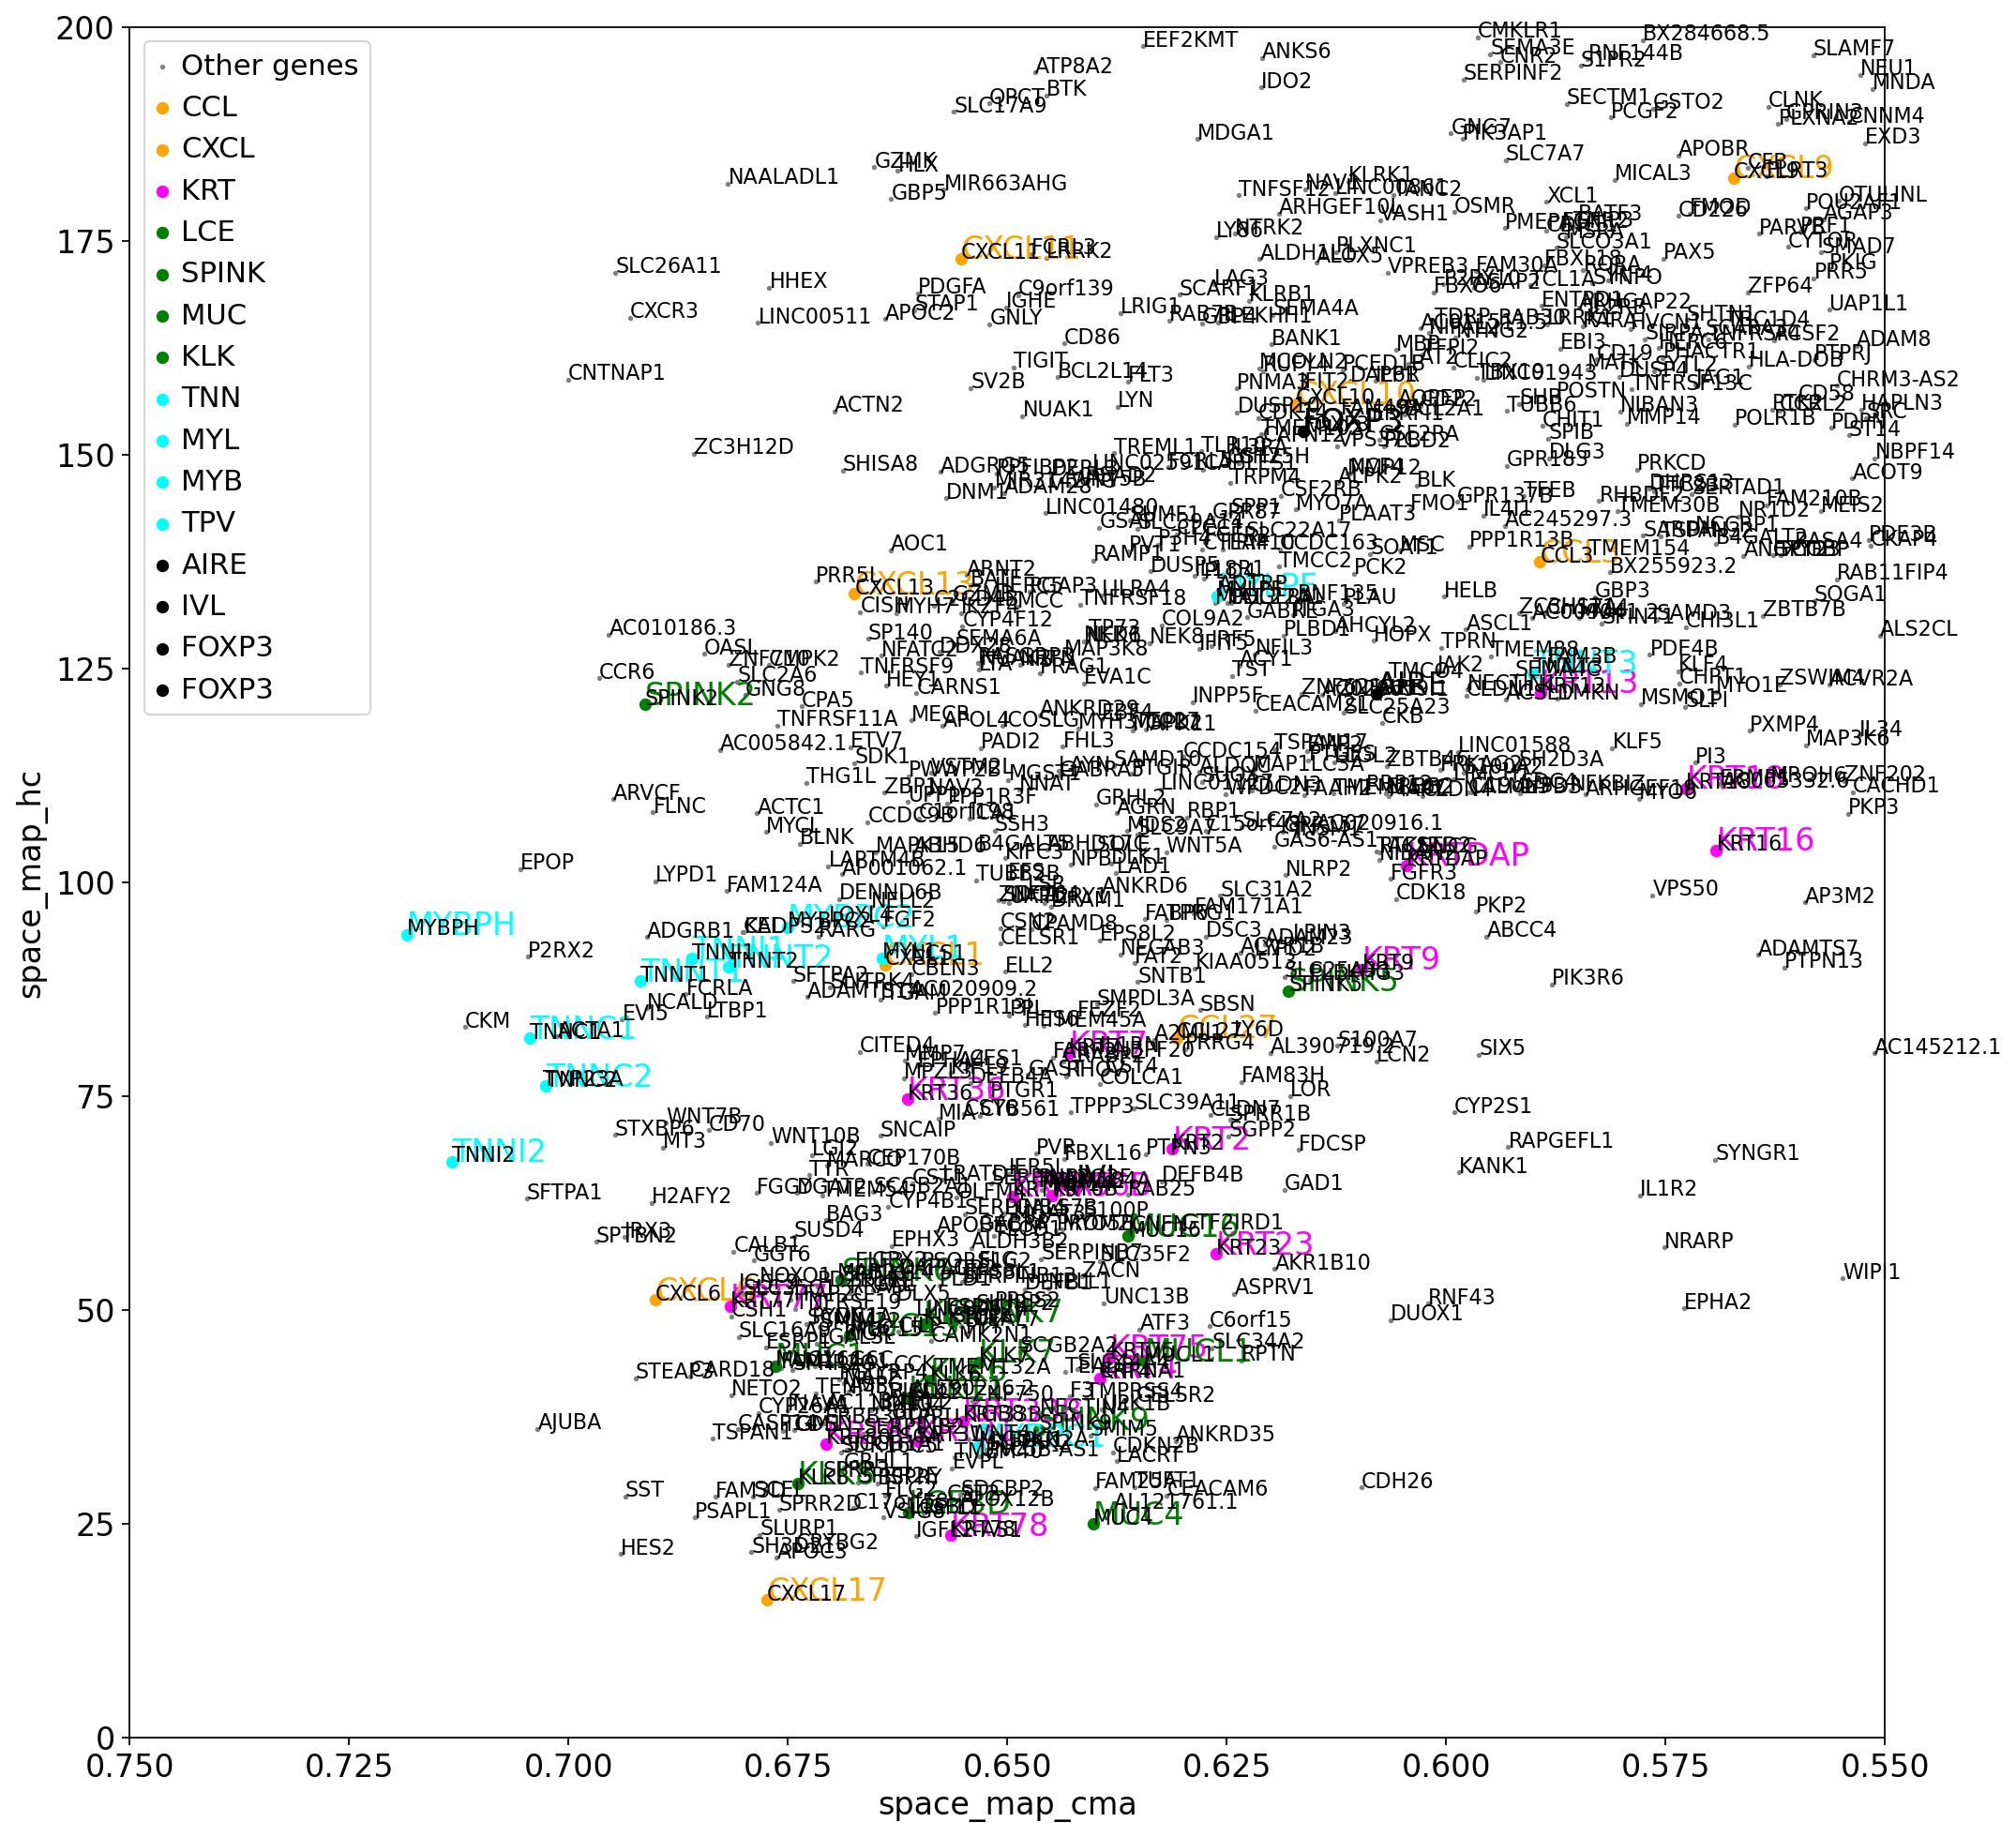

In [128]:
import matplotlib.pyplot as plt
import numpy as np

def annotate_matching_positions(df,search_string, color,anno=True):
    matching_positions = np.where(df.index.str.contains(search_string))[0]
    df_tmp = df.iloc[matching_positions, :]
    plt.scatter(df_tmp['space_map_cma'], df_tmp['space_map_hc'], c=color, label=search_string, s=25)
    for i in matching_positions:
        if anno:
            plt.annotate(df.index[i], (df['space_map_cma'][i], df['space_map_hc'][i]), fontname='Arial', fontsize=15, color=color)

plt.figure(figsize=[15, 15])

cmap = plt.get_cmap('tab20_r')
colors = [cmap(i) for i in range(len(marker_dict_1))]

# Adding unique markers
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
# for idx, key in enumerate(marker_dict_1.keys()):
#     if 'TEC' in key:
#         plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=[colors[idx]], label=key + '_unique', s=50)

# Define strings to search for and corresponding colors
search_strings = ['CCL', 'CXCL', 'KRT', 'LCE', 'SPINK','MUC', 'KLK','TNN','MYL','MYB','TPV','AIRE','IVL','FOXP3','FOXP3','SYT8']
colors = ['orange', 'orange', 'magenta','green', 'green', 'green','green','cyan','cyan','cyan','cyan','black','black','black','black']
# Define strings to search for and corresponding colors
# search_strings = ['KRT','IVL']
# colors = ['green','magenta']

# Use a loop to match partial strings, plot scatter points, and add annotations
for search_string, color in zip(search_strings, colors):
    annotate_matching_positions(df,search_string, color)

# Annotate all the spots with their index values
for i, (x, y) in enumerate(zip(df['space_map_cma'], df['space_map_hc'])):
    plt.annotate(df.index[i], (x, y), fontname='Arial', fontsize=10, color='black')

plt.grid(False)
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')
plt.legend()
plt.gca().invert_xaxis()
plt.xlim(0.75, 0.55)
plt.ylim(0, 200)
# 
# plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/scatter_specific_gene_association.pdf', format='pdf')  # Save to PDF
plt.show()


## Load TEC adata

In [5]:
adata_tec = sc.read("../Figure1/annotation_done/TEC_spatlas_scvi_dbrm_2023-07-19.h5ad")

In [6]:
adata_tec_paed = adata_tec[~(adata_tec.obs['age_group'] == 'fetal'),:].copy()
adata_tec_paed_med = adata_tec_paed[adata_tec_paed.obs['annotation_level_3'].isin([ 'mTECI',
       'mTECI-trans', 'mTECII', 'mTECIII', 'TEC-neuro', 'TEC-cilliated',
       'TEC-myo'])]
adata_tec_paed_med

View of AnnData object with n_obs × n_vars = 6945 × 36751
    obs: 'age_group', 'age_numeric', 'annotation_level_0', 'annotation_level_1', 'annotation_level_2', 'annotation_level_3', 'backup_barcode', 'barcode_sequence', 'batch', 'bh_pval', 'c_call_VDJ', 'c_call_VDJ_main', 'c_call_VJ', 'c_call_VJ_main', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'c_call_gdT_VDJ', 'c_call_gdT_VJ', 'cc_phase', 'chain_status', 'chemistry', 'chemistry_simple', 'cite_w_protein', 'clone_id', 'clone_id_by_size', 'cluster_scrublet_score', 'ctp_pred', 'ctp_pred_prob', 'ctp_pred_uncertain', 'd_call_VDJ', 'd_call_VDJ_main', 'd_call_abT_VDJ', 'd_call_abT_VDJ_main', 'donor', 'doublet_score', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'enrichment', 'enzyme', 'g2m_Score', 'good_qc_cluster_mito20', 'has_contig', 'isotype', 'isotype_status', 'j_call_VDJ', 'j_call_VDJ_main', 'j_call_VJ', 'j_call_VJ_main', 'j_call_abT_VDJ', 'j_call_abT_VDJ_main', 'j_call_abT_VJ', 'j_call_abT_VJ_main', 'j_call_gdT_VDJ', 'j_call_gdT_VDJ_

In [7]:
sc.set_figure_params(figsize=[10,10],fontsize=30)
sc.pp.neighbors(adata_tec_paed_med,use_rep='X_scVI')
sc.tl.umap(adata_tec_paed_med)

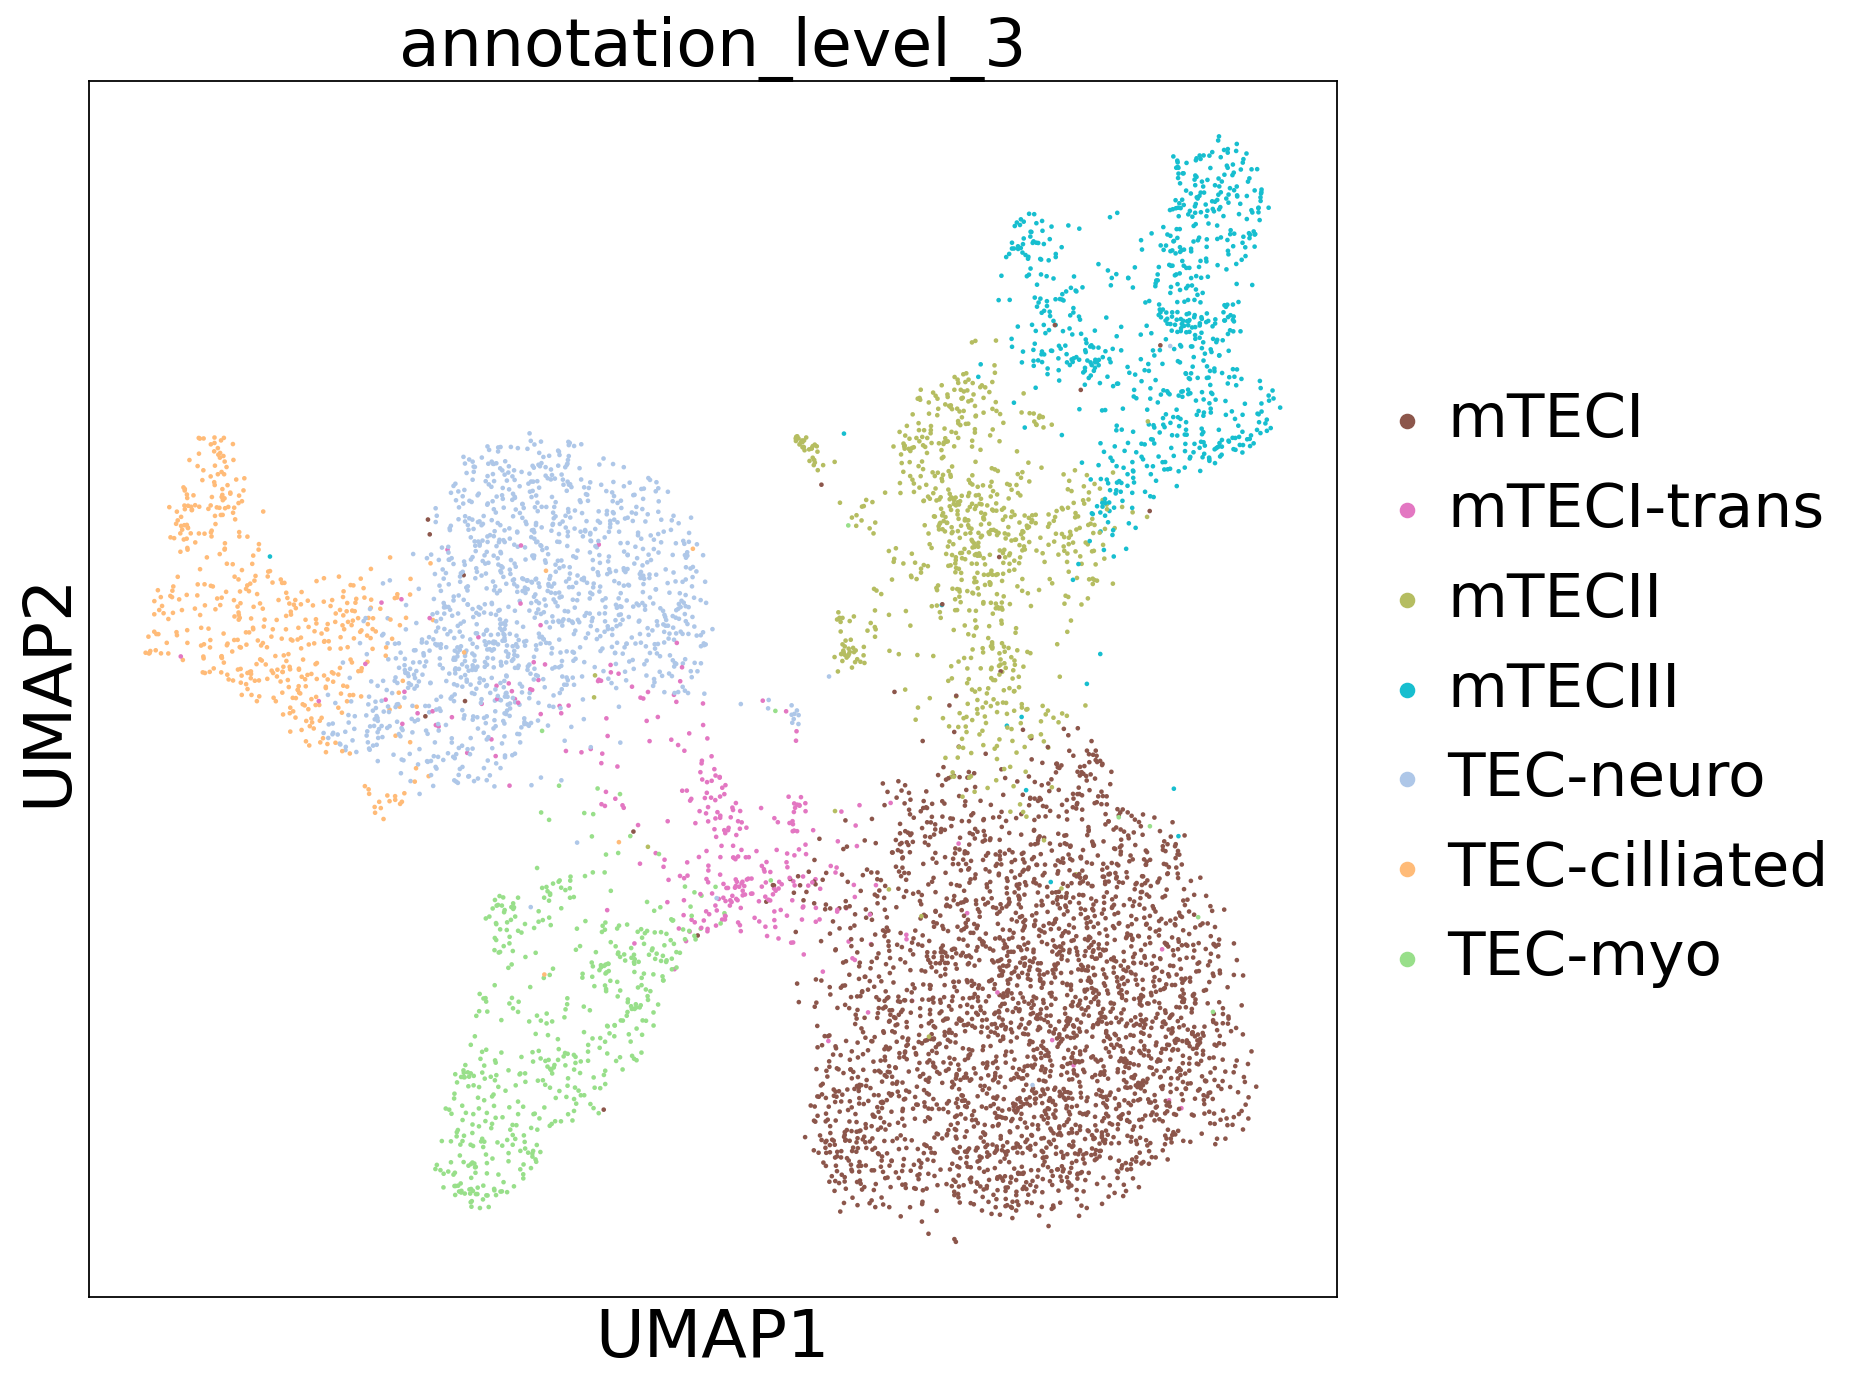

In [8]:
sc.pl.umap(adata_tec_paed_med, color = ['annotation_level_3'],save='_mTEC_HC_fig.pdf')

In [8]:
adata_tec_paed.obs['annotation_level_3'].cat.categories

Index(['cTECI', 'cTECII', 'cTECIII', 'mcTEC', 'mcTEC-Prolif', 'mTECI',
       'mTECI-trans', 'mTECII', 'mTECIII', 'TEC-neuro', 'TEC-cilliated',
       'TEC-myo'],
      dtype='object')

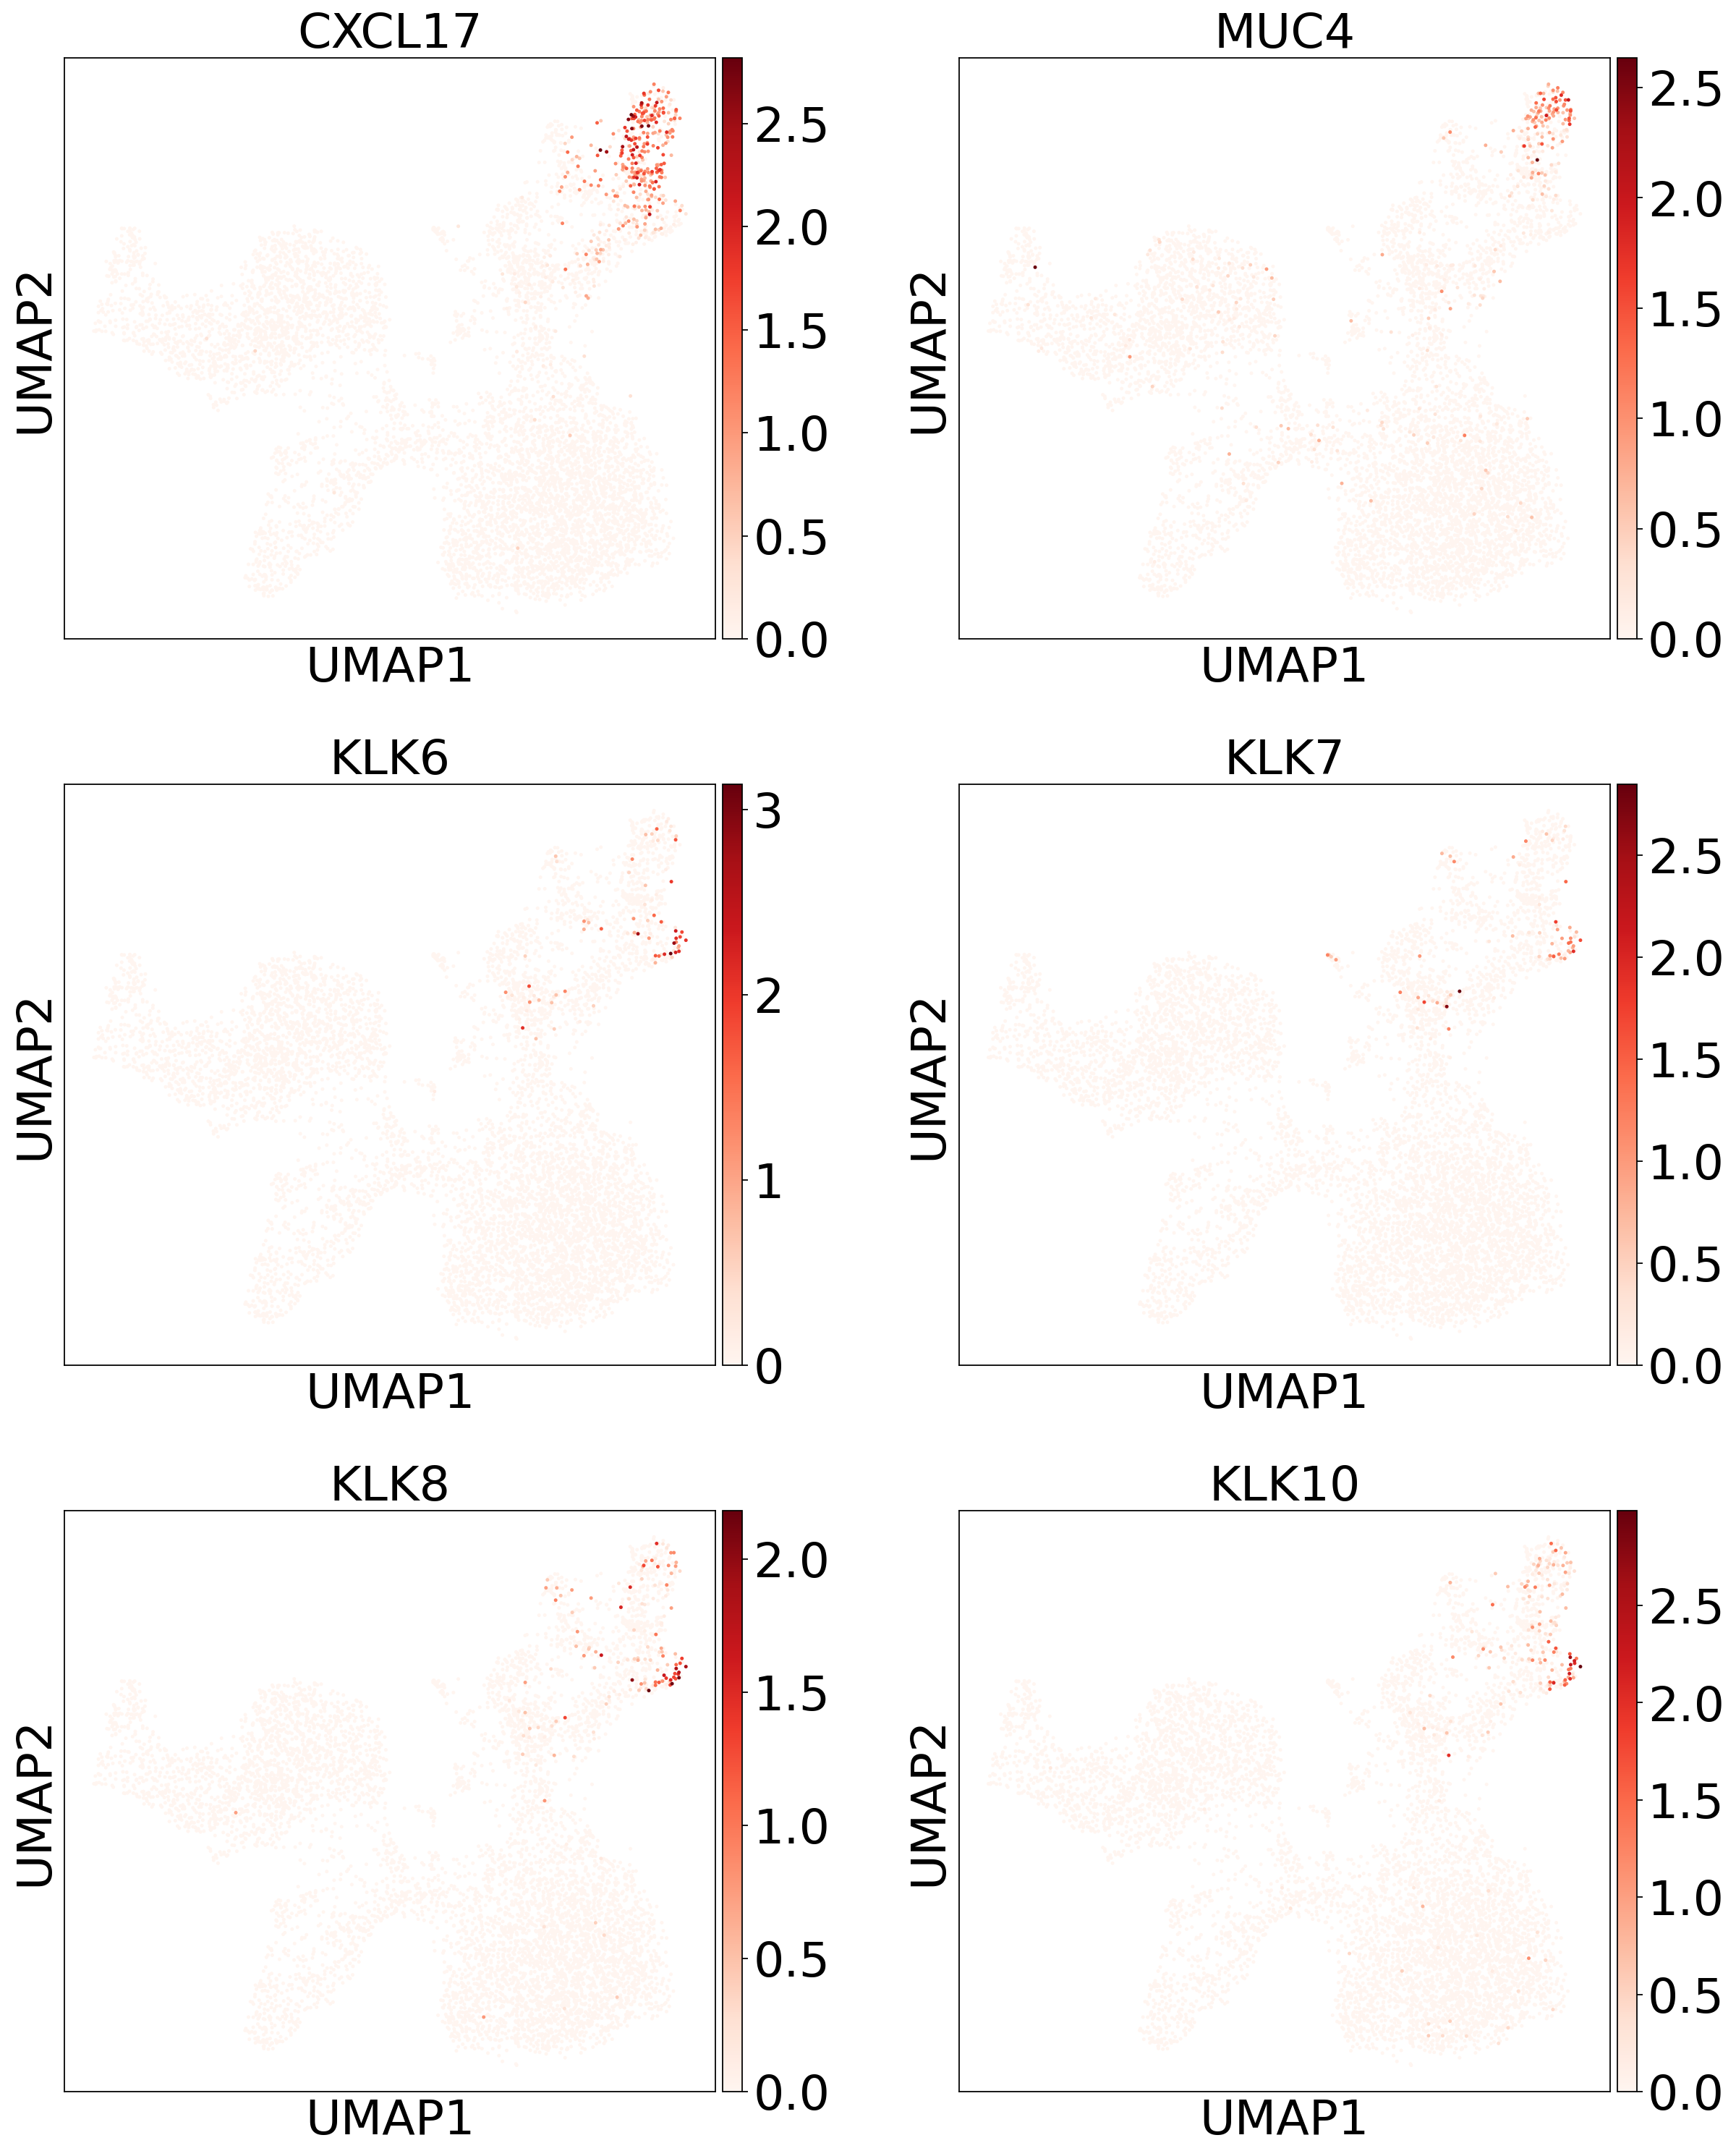

In [9]:
sc.set_figure_params(figsize=[7,7],fontsize=30)
sc.pl.umap(adata_tec_paed_med, color = [ 'CXCL17','MUC4','KLK6','KLK7','KLK8','KLK10'], legend_loc = "on data", legend_fontsize = 30,ncols=2,s=20,wspace=0.25,cmap='Reds',save='_mTECIII_HC_fig.pdf')

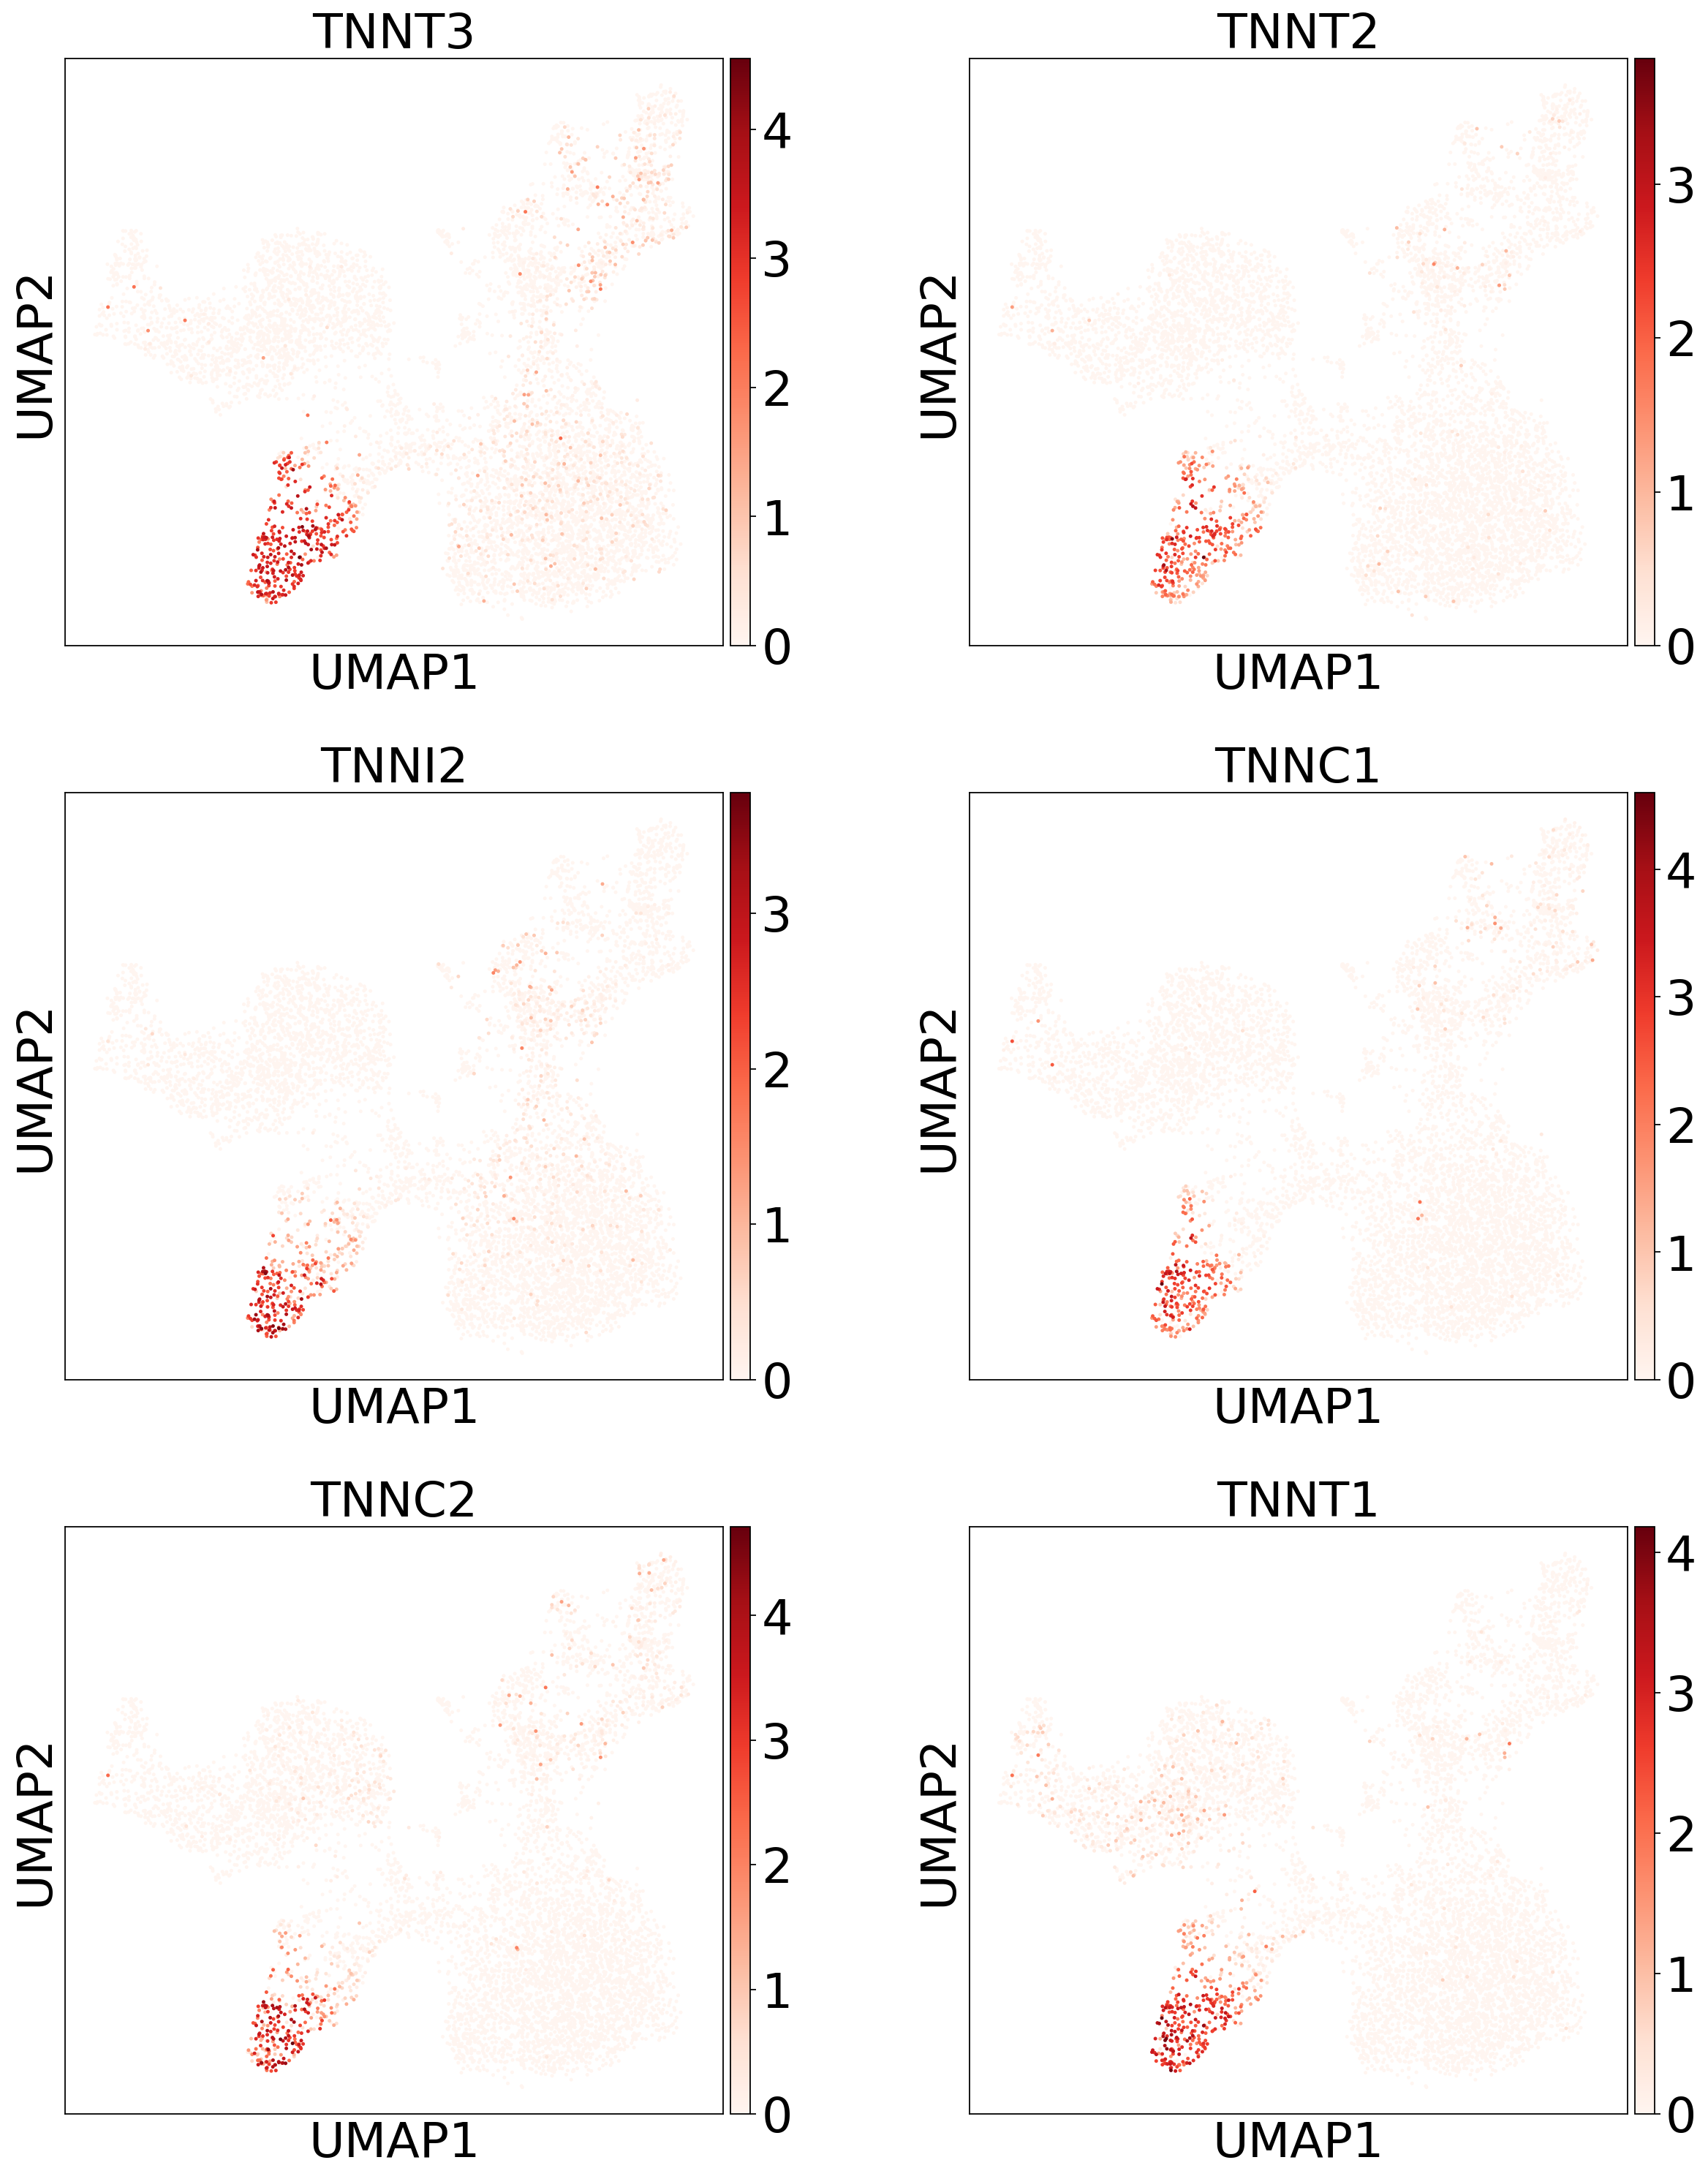

In [10]:
sc.set_figure_params(figsize=[7,7],fontsize=30)
sc.pl.umap(adata_tec_paed_med, color = [ 'TNNT3','TNNT2','TNNI2','TNNC1','TNNC2','TNNT1',], legend_loc = "on data", legend_fontsize = 30,ncols=2,s=20,wspace=0.25,cmap='Reds',save='_myoTEC_HC_fig.pdf')

In [11]:
col = adata_tec_paed.uns['annotation_level_3_colors']
cat = adata_tec_paed.obs['annotation_level_3'].cat.categories

In [12]:
color_dict = {category: color for category, color in zip(cat, col)}
color_dict

{'cTECI': '#1f77b4',
 'cTECII': '#ff7f0e',
 'cTECIII': '#279e68',
 'mcTEC': '#d62728',
 'mcTEC-Prolif': '#aa40fc',
 'mTECI': '#8c564b',
 'mTECI-trans': '#e377c2',
 'mTECII': '#b5bd61',
 'mTECIII': '#17becf',
 'TEC-neuro': '#aec7e8',
 'TEC-cilliated': '#ffbb78',
 'TEC-myo': '#98df8a'}

space_map_cma  space_map_hc  B-memory_unique  DC1_unique  \
AGRN             0.637555    108.020218            False       False   
AL390719.2       0.620003     80.047811            False       False   
TNFRSF18         0.641657    132.434995            False       False   
TNFRSF4          0.570152    163.429201            False       False   
TP73             0.640746    128.983331            False       False   
...                   ...           ...              ...         ...   
SLITRK2          0.652333     33.658415            False       False   
GABRE            0.622722    130.940622            False       False   
PNMA3            0.623894    157.701285            False       False   
CLIC2            0.599161    160.155270            False       False   
AC145212.1       0.551247     79.979523            False       False   

            Macrophage-APOC2_unique  TEC-myo_unique  T_CD8αα(II)_unique  \
AGRN                          False           False               False   
AL390719.2                    False           False               False   
TNFRSF18                      False           False               False   
TNFRSF4                       False           False               False   
TP73                          False           False               False   
...                             ...             ...                 ...   
SLITRK2                       False           False               False   
GABRE                         False           False               False   
PNMA3                         False           False               False   
CLIC2                         False           False               False   
AC145212.1                    False           False               False   

            T_NK_unique  T_Treg_recirc_unique  aDC3_unique  mTECII_unique  \
AGRN              False                 False        False          False   
AL390719.2        False                 False        False          False   
TNFRSF18          False                  True        False          False   
TNFRSF4           False                 False        False          False   
TP73              False                 False        False          False   
...                 ...                   ...          ...            ...   
SLITRK2           False                 False        False          False   
GABRE             False                 False        False          False   
PNMA3             False                 False        False          False   
CLIC2             False                 False        False          False   
AC145212.1        False                 False        False          False   

            mTECIII_unique  pDC_unique  
AGRN                 False       False  
AL390719.2           False       False  
TNFRSF18             False       False  
TNFRSF4              False       False  
TP73                 False       False  
...                    ...         ...  
SLITRK2              False       False  
GABRE                False       False  
PNMA3                False       False  
CLIC2                False       False  
AC145212.1           False       False  

[851 rows x 13 columns]

Text(0.5752165710742426, 172.87944691638992, 'B-memory')

Text(0.5828634571070898, 161.0929593564473, 'B-memory')

Text(0.6029083840998978, 155.7034971288428, 'B-memory')

Text(0.6105584095829942, 204.18222448951238, 'DC1')

Text(0.611231697754329, 147.74850613019706, 'Macrophage-APOC2')

Text(0.6817775522411504, 90.07065893838092, 'TEC-myo')

Text(0.6859524972275348, 91.01892759855409, 'TEC-myo')

Text(0.7184081172053411, 93.81774457747046, 'TEC-myo')

Text(0.7012512525468032, 81.94460176684274, 'TEC-myo')

Text(0.6642432713410047, 91.08715746736698, 'TEC-myo')

Text(0.7044007662854525, 81.72516123968316, 'TEC-myo')

Text(0.6903650623297757, 108.16703345610843, 'TEC-myo')

Text(0.7132177055306556, 67.29122107315837, 'TEC-myo')

Text(0.5900393973601942, 124.45351865338591, 'TEC-myo')

Text(0.6626649108753487, 131.43182548291975, 'TEC-myo')

Text(0.6785080184665218, 108.04591591246103, 'TEC-myo')

Text(0.6260511266992487, 133.3984410550933, 'TEC-myo')

Text(0.6419279945033095, 117.95209573228608, 'TEC-myo')

Text(0.6814044947395125, 49.22472324483122, 'TEC-myo')

Text(0.7118043803847911, 83.03347123579782, 'TEC-myo')

Text(0.6610047513494021, 86.70460806063693, 'TEC-myo')

Text(0.6918197531429626, 88.43007515661266, 'TEC-myo')

Text(0.7025984404210903, 76.10590838660899, 'TEC-myo')

Text(0.6153184393442421, 208.38812039860113, 'T_CD8αα(II)')

Text(0.6520016800827871, 165.19041553358852, 'T_NK')

Text(0.6224568167560175, 167.97276516973827, 'T_NK')

Text(0.6416567628706458, 132.43499466803505, 'T_Treg_recirc')

Text(0.5957054374171656, 158.7676066074907, 'T_Treg_recirc')

Text(0.6493001012458959, 160.1855174491913, 'T_Treg_recirc')

Text(0.6264169673393944, 169.88458604779382, 'T_Treg_recirc')

Text(0.6210506862856383, 192.92548731335228, 'aDC3')

Text(0.5813260628789517, 136.20723020752317, 'aDC3')

Text(0.6612159221208153, 26.236789016046703, 'mTECII')

Text(0.6744859742061121, 42.94183211874238, 'mTECII')

Text(0.670551717874304, 66.82990215969448, 'mTECII')

Text(0.6629979334468769, 42.84611239425876, 'mTECII')

Text(0.6935236132693081, 28.131593143304585, 'mTECII')

Text(0.616847371564333, 68.68890885962433, 'mTECII')

Text(0.6342777085674919, 95.64670465072008, 'mTECII')

Text(0.6323746383600284, 64.96786842697588, 'mTECII')

Text(0.6542360698311829, 76.51342407274686, 'mTECII')

Text(0.6744142960306647, 88.38935719889585, 'mTECII')

Text(0.7047668451218749, 62.96436954599161, 'mTECII')

Text(0.6485422648206471, 45.02659881964357, 'mTECII')

Text(0.668334883597085, 33.580863960181205, 'mTECII')

Text(0.6616727172780402, 79.17175589063451, 'mTECII')

Text(0.6762571453897929, 20.982191518912604, 'mTECII')

Text(0.6375020550389938, 32.28258285790517, 'mTECII')

Text(0.6891958018509469, 68.94888696506007, 'mTECII')

Text(0.6476179977763082, 77.42950914971777, 'mTECII')

Text(0.6547469533003684, 47.224914238221686, 'mTECII')

Text(0.6427415759518545, 101.99824349369666, 'mTECII')

Text(0.6726024380820547, 65.69223193537785, 'mTECII')

Text(0.6840392290417302, 70.96371516378855, 'mTECII')

Text(0.6578686572517787, 72.30660823632647, 'mTECII')

Text(0.6387775715887372, 77.77395088956753, 'mTECII')

Text(0.6608099559008642, 64.70225914519223, 'mTECII')

Text(0.6569050289756051, 27.705534845289055, 'mTECII')

Text(0.6079688403403133, 121.97903395010887, 'mTECII')

Text(0.6463690048831191, 64.74391608434071, 'mTECIII')

Text(0.6635590647740764, 61.960605485237494, 'mTECIII')

Text(0.6716514212530432, 52.70332947551867, 'mTECIII')

Text(0.6232905232413641, 44.077655053705215, 'mTECIII')

Text(0.6532302465045967, 55.004391397188456, 'mTECIII')

Text(0.6639325447963514, 28.206270759687698, 'mTECIII')

Text(0.6420923883561135, 64.27816678546397, 'mTECIII')

Text(0.6709647399503224, 30.491119633931714, 'mTECIII')

Text(0.6246258166705531, 72.19365579653791, 'mTECIII')

Text(0.6760137598533343, 26.57864785572218, 'mTECIII')

Text(0.6669563367165356, 29.806642885666864, 'mTECIII')

Text(0.6177662381957267, 74.9959135862545, 'mTECIII')

Text(0.6123982177843371, 80.81847282162907, 'mTECIII')

Text(0.6463269062941077, 37.88013669128183, 'mTECIII')

Text(0.6686426018723327, 46.54006187282647, 'mTECIII')

Text(0.6504890744881666, 97.80977707251525, 'mTECIII')

Text(0.669345964981966, 53.64276530672167, 'mTECIII')

Text(0.6560478801582603, 32.68476589913831, 'mTECIII')

Text(0.6832673895087941, 28.08083208916675, 'mTECIII')

Text(0.6392080445956302, 38.318555005935394, 'mTECIII')

Text(0.6401995035340172, 24.944287534873872, 'mTECIII')

Text(0.6412987830963799, 60.87964388449013, 'mTECIII')

Text(0.6707068439535773, 38.420929004038285, 'mTECIII')

Text(0.6179492461378006, 87.23044304615316, 'mTECIII')

Text(0.6562358195183062, 48.62518933377789, 'mTECIII')

Text(0.6464304558600695, 35.941071906574415, 'mTECIII')

Text(0.6532366200348768, 59.31189482589167, 'mTECIII')

Text(0.6269311166206887, 48.04033128905691, 'mTECIII')

Text(0.6742943940383447, 35.86415851224197, 'mTECIII')

Text(0.6597150658520271, 54.98439410773427, 'mTECIII')

Text(0.6718788722960347, 43.38098413072324, 'mTECIII')

Text(0.668980262918029, 33.31379093217532, 'mTECIII')

Text(0.6686316219971301, 41.37660136365023, 'mTECIII')

Text(0.6635611629399956, 34.388171979516756, 'mTECIII')

Text(0.6218761872699017, 91.40210032102382, 'mTECIII')

Text(0.6536125575866572, 50.046088110206156, 'mTECIII')

Text(0.6241269591758128, 82.02629126091742, 'mTECIII')

Text(0.6379343188806178, 33.32038467856229, 'mTECIII')

Text(0.6079189722372569, 79.05147885937266, 'mTECIII')

Text(0.5975322882185009, 110.44143960248124, 'mTECIII')

Text(0.6805789105706748, 46.76710367431938, 'mTECIII')

Text(0.6400144933952132, 29.117865898134323, 'mTECIII')

Text(0.6548974564569213, 72.83460012239533, 'mTECIII')

Text(0.6541148686106978, 57.19954126302422, 'mTECIII')

Text(0.6861668677236784, 42.207711153802684, 'mTECIII')

Text(0.6332704149723208, 81.5592245872182, 'mTECIII')

Text(0.6706634910875232, 34.30024223876384, 'mTECIII')

Text(0.6383126562736441, 44.43188098910821, 'mTECIII')

Text(0.6449301143569163, 63.35006967705155, 'mTECIII')

Text(0.6815722813082019, 50.366598851258885, 'mTECIII')

Text(0.6394665949438302, 41.989831217678514, 'mTECIII')

Text(0.6494000509602099, 63.25690723031681, 'mTECIII')

Text(0.6564476047217557, 23.60849349629623, 'mTECIII')

Text(0.6789532468171516, 28.180015076350443, 'mTECIII')

Text(0.6680459915271586, 40.440512341208574, 'mTECIII')

Text(0.6722230432984408, 48.45697174429651, 'mTECIII')

Text(0.6261914694025833, 56.490118619352664, 'mTECIII')

Text(0.6405134591585663, 35.266347226587335, 'mTECIII')

Text(0.6551657493524794, 53.21832823330724, 'mTECIII')

Text(0.6548465716125784, 61.16309733554586, 'mTECIII')

Text(0.6518419938710313, 64.72781683920138, 'mTECIII')

Text(0.646159647751597, 55.90957992119578, 'mTECIII')

Text(0.6664679405352327, 35.480290422292356, 'mTECIII')

Text(0.6807274493040513, 36.01419485201452, 'mTECIII')

Text(0.6044787742376564, 101.9615138331498, 'mTECIII')

Text(0.5971838363469741, 110.52809566477394, 'mTECIII')

Text(0.6318262720634547, 28.253625138446377, 'mTECIII')

Text(0.6774035642339545, 16.02828868160084, 'mTECIII')

Text(0.6604237657272997, 23.506198577175738, 'mTECIII')

Text(0.6587893466590177, 41.71784027156993, 'mTECIII')

Text(0.6532516532755396, 43.808748835209485, 'mTECIII')

Text(0.673856473375594, 29.61860723434776, 'mTECIII')

Text(0.6595312672704071, 48.3395498594039, 'mTECIII')

Text(0.6378385078269194, 26.775145918700133, 'mTECIII')

Text(0.5715876087412389, 113.96316756580296, 'mTECIII')

Text(0.5727492999541748, 120.47555416538455, 'mTECIII')

Text(0.6580211407206694, 59.113422050173156, 'mTECIII')

Text(0.6276373191053964, 135.52802006025598, 'pDC')

Text(0.6392040904985606, 133.53981611456973, 'pDC')

Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 250.0)

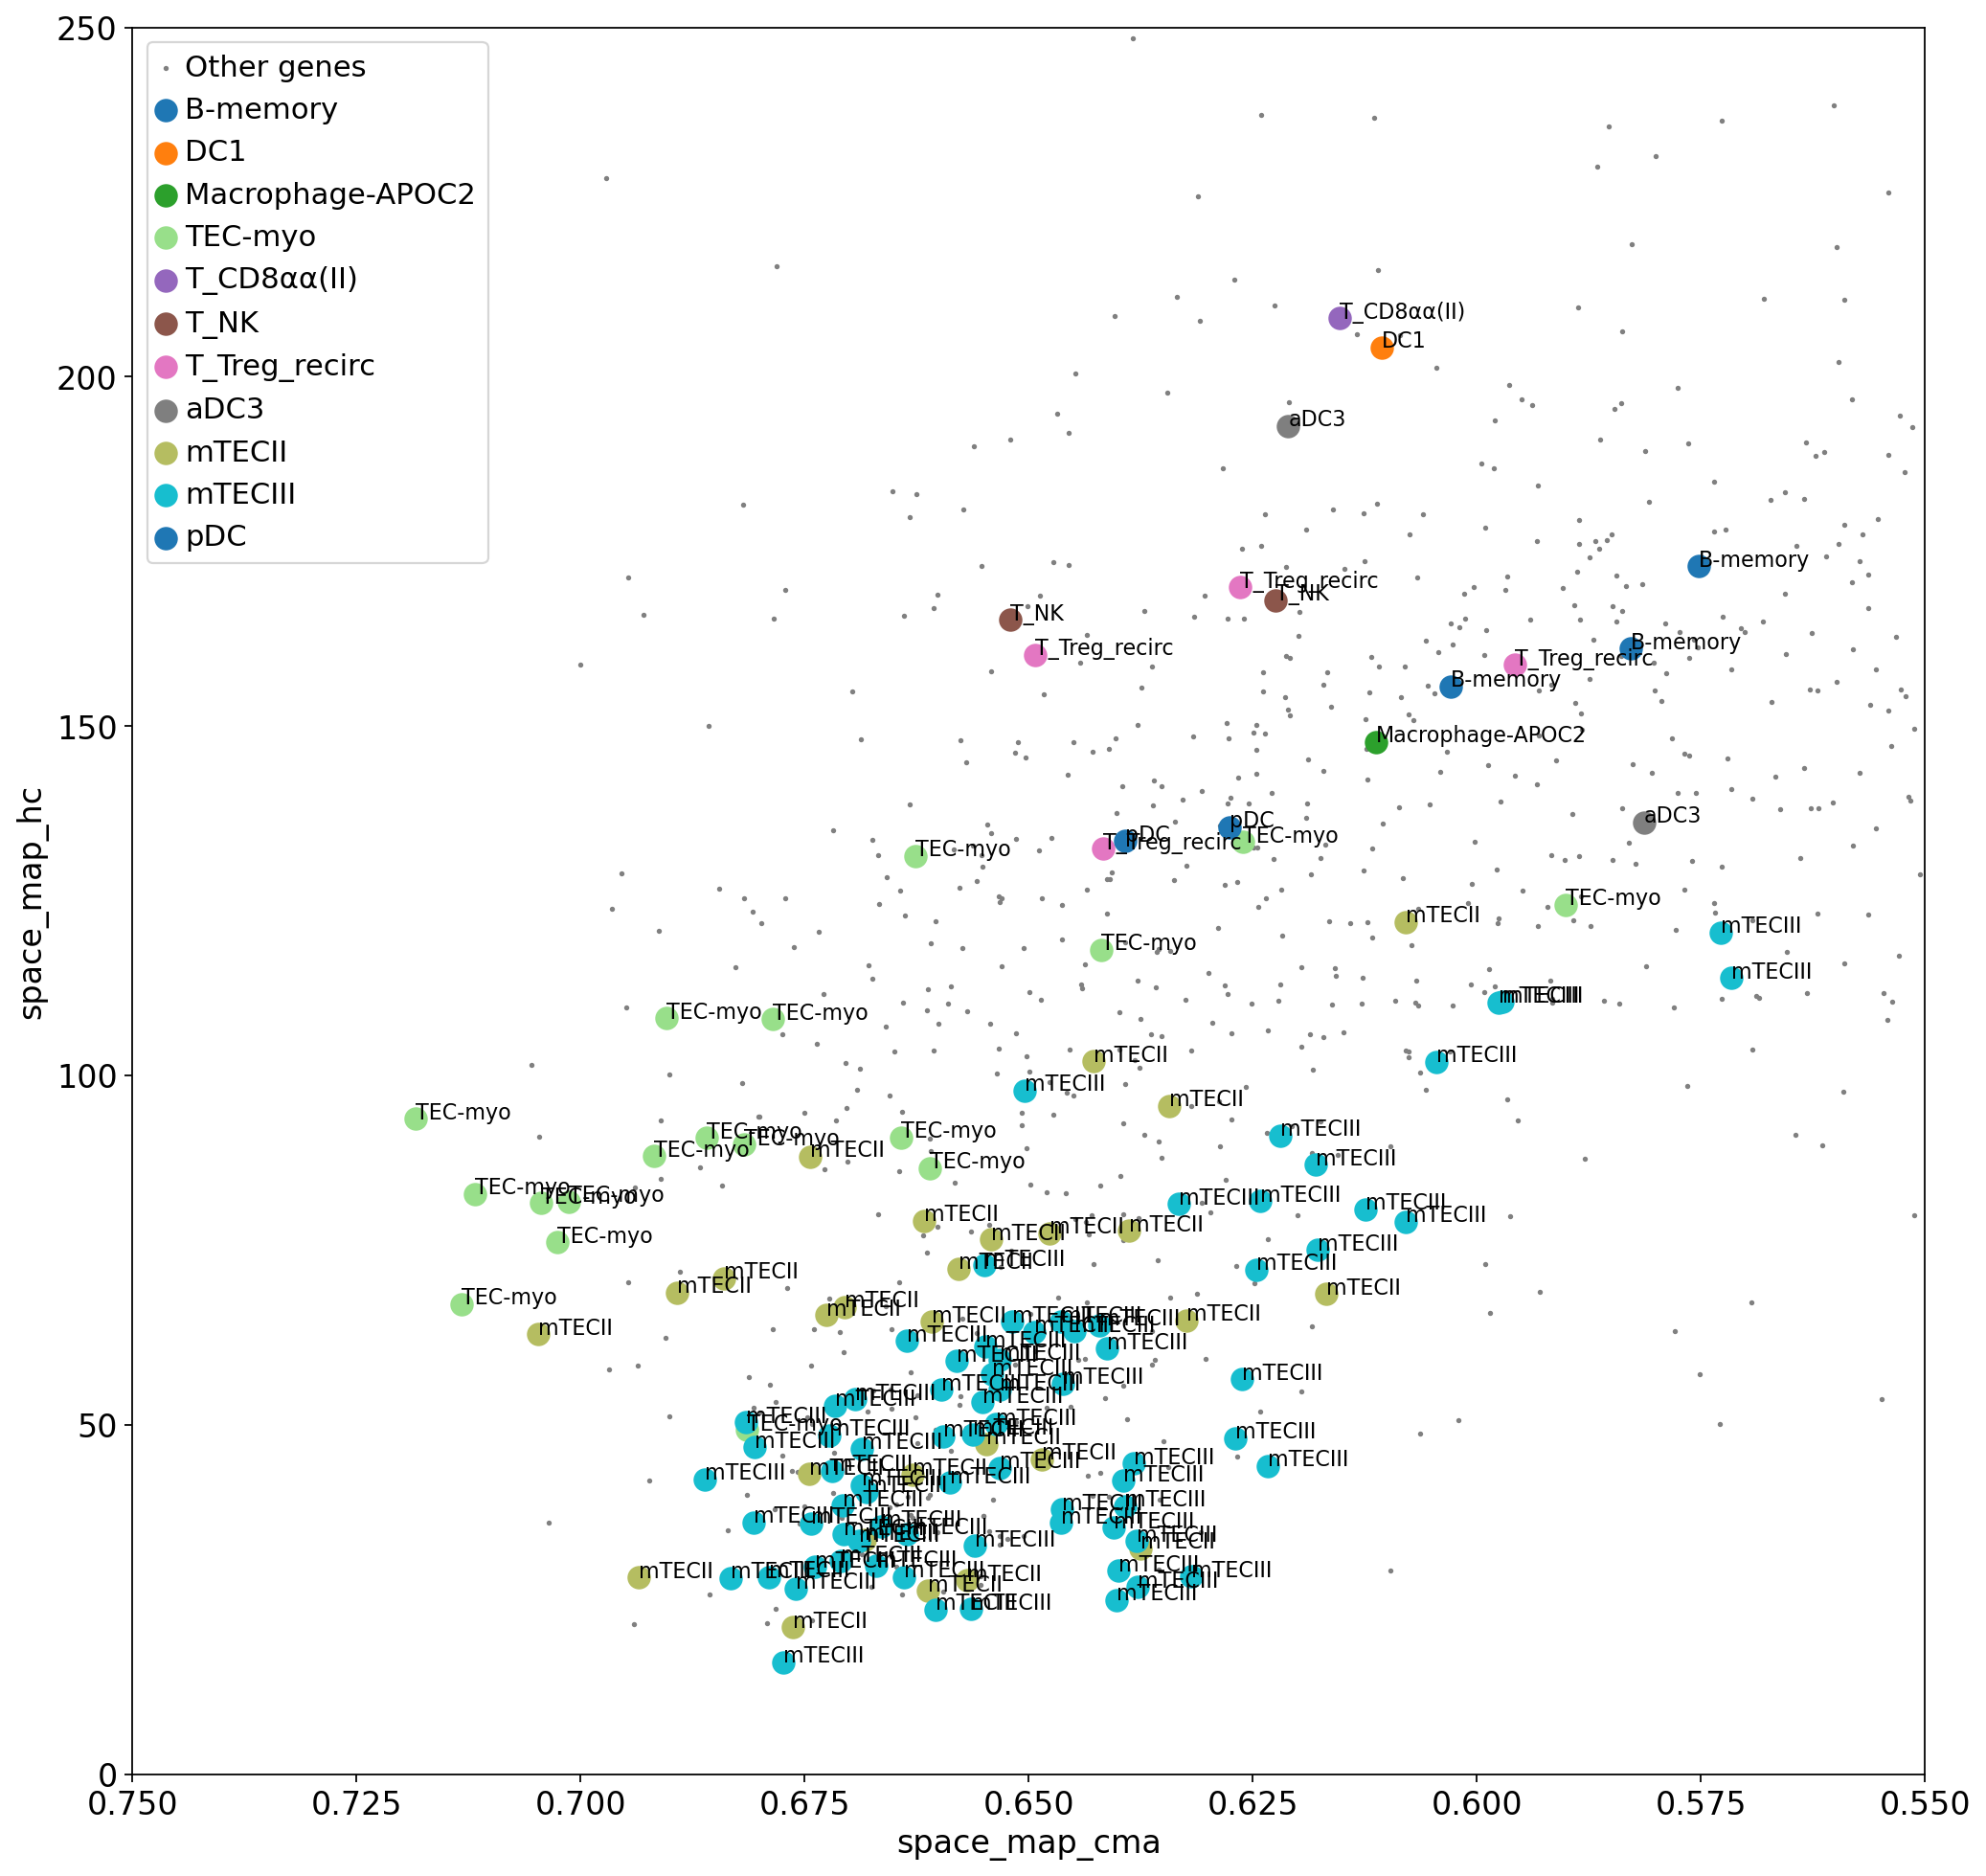

In [68]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])
df

colors = sns.color_palette('tab10', 20)
# cmap = ListedColormap(colors)

plt.scatter(df['space_map_cma'], df['space_map_hc'], c='gray', label='Other genes', s=2)
for idx, key in enumerate(marker_dict_1.keys()):
    if 'TEC' in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'], c=color_dict[key], label=key, s=100)
        filtered_df = df[df[key + '_unique']]
        for _, row in filtered_df.iterrows():
            plt.annotate(
                key, 
                (row['space_map_cma'], row['space_map_hc']), 
                fontname='Arial', 
                fontsize=10, 
                color='black'
            )
    if 'TEC' not in key:
        plt.scatter(df[df[key + '_unique']]['space_map_cma'], df[df[key + '_unique']]['space_map_hc'],  c=[colors[idx]], label=key, s=100)
        filtered_df = df[df[key + '_unique']]
        for _, row in filtered_df.iterrows():
            plt.annotate(
                key, 
                (row['space_map_cma'], row['space_map_hc']), 
                fontname='Arial', 
                fontsize=10, 
                color='black'
            )


        
plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 250)

plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_CMA_association_genes_all.pdf')
plt.show()


{'B-memory': 3, 'DC1': 1, 'Macrophage-APOC2': 1, 'TEC-myo': 18, 'T_CD8αα(II)': 1, 'T_NK': 2, 'T_Treg_recirc': 4, 'aDC3': 2, 'mTECII': 27, 'mTECIII': 77, 'pDC': 2}
138


Text(0.6817775522411504, 90.07065893838092, 'TNNT2')

Text(0.6859524972275348, 91.01892759855409, 'TNNI1')

Text(0.7184081172053411, 93.81774457747046, 'MYBPH')

Text(0.7012512525468032, 81.94460176684274, 'ACTA1')

Text(0.6642432713410047, 91.08715746736698, 'MYL1')

Text(0.7044007662854525, 81.72516123968316, 'TNNC1')

Text(0.6903650623297757, 108.16703345610843, 'FLNC')

Text(0.7132177055306556, 67.29122107315837, 'TNNI2')

Text(0.5900393973601942, 124.45351865338591, 'TNNT3')

Text(0.6626649108753487, 131.43182548291975, 'MYH7')

Text(0.6785080184665218, 108.04591591246103, 'ACTC1')

Text(0.6260511266992487, 133.3984410550933, 'MYLPF')

Text(0.6419279945033095, 117.95209573228608, 'MYH3')

Text(0.6814044947395125, 49.22472324483122, 'CSH1')

Text(0.7118043803847911, 83.03347123579782, 'CKM')

Text(0.6610047513494021, 86.70460806063693, 'AC020909.2')

Text(0.6918197531429626, 88.43007515661266, 'TNNT1')

Text(0.7025984404210903, 76.10590838660899, 'TNNC2')

Text(0.6612159221208153, 26.236789016046703, 'LCE3D')

Text(0.6744859742061121, 42.94183211874238, 'SPRR2G')

Text(0.670551717874304, 66.82990215969448, 'MARCO')

Text(0.6629979334468769, 42.84611239425876, 'CCK')

Text(0.6935236132693081, 28.131593143304585, 'SST')

Text(0.616847371564333, 68.68890885962433, 'FDCSP')

Text(0.6342777085674919, 95.64670465072008, 'FABP6')

Text(0.6323746383600284, 64.96786842697588, 'DEFB4B')

Text(0.6542360698311829, 76.51342407274686, 'DEFB4A')

Text(0.6744142960306647, 88.38935719889585, 'SFTPA2')

Text(0.7047668451218749, 62.96436954599161, 'SFTPA1')

Text(0.6485422648206471, 45.02659881964357, 'SCGB2A2')

Text(0.668334883597085, 33.580863960181205, 'SCGB1A1')

Text(0.6616727172780402, 79.17175589063451, 'MMP7')

Text(0.6762571453897929, 20.982191518912604, 'APOC3')

Text(0.6375020550389938, 32.28258285790517, 'LACRT')

Text(0.6891958018509469, 68.94888696506007, 'MT3')

Text(0.6476179977763082, 77.42950914971777, 'GAST')

Text(0.6547469533003684, 47.224914238221686, 'PYY')

Text(0.6427415759518545, 101.99824349369666, 'NPB')

Text(0.6726024380820547, 65.69223193537785, 'TTR')

Text(0.6840392290417302, 70.96371516378855, 'CD70')

Text(0.6578686572517787, 72.30660823632647, 'MIA')

Text(0.6387775715887372, 77.77395088956753, 'CST4')

Text(0.6608099559008642, 64.70225914519223, 'CST1')

Text(0.6569050289756051, 27.705534845289055, 'CST2')

Text(0.6079688403403133, 121.97903395010887, 'AIRE')

Text(0.6463690048831191, 64.74391608434071, 'PLA2G2F')

Text(0.6635590647740764, 61.960605485237494, 'CYP4B1')

Text(0.6716514212530432, 52.70332947551867, 'PDZK1IP1')

Text(0.6232905232413641, 44.077655053705215, 'RPTN')

Text(0.6532302465045967, 55.004391397188456, 'FLG')

Text(0.6639325447963514, 28.206270759687698, 'FLG2')

Text(0.6420923883561135, 64.27816678546397, 'IVL')

Text(0.6709647399503224, 30.491119633931714, 'SPRR3')

Text(0.6246258166705531, 72.19365579653791, 'SPRR1B')

Text(0.6760137598533343, 26.57864785572218, 'SPRR2D')

Text(0.6669563367165356, 29.806642885666864, 'SPRR2E')

Text(0.6177662381957267, 74.9959135862545, 'LOR')

Text(0.6123982177843371, 80.81847282162907, 'S100A7')

Text(0.6463269062941077, 37.88013669128183, 'NECTIN4')

Text(0.6686426018723327, 46.54006187282647, 'PIGR')

Text(0.6504890744881666, 97.80977707251525, 'SDC1')

Text(0.669345964981966, 53.64276530672167, 'MAB21L4')

Text(0.6560478801582603, 32.68476589913831, 'TMEM40')

Text(0.6832673895087941, 28.08083208916675, 'FAM3D')

Text(0.6392080445956302, 38.318555005935394, 'UPK1B')

Text(0.6401995035340172, 24.944287534873872, 'MUC4')

Text(0.6412987830963799, 60.87964388449013, 'S100P')

Text(0.6707068439535773, 38.420929004038285, 'AC113410.2')

Text(0.6179492461378006, 87.23044304615316, 'SPINK5')

Text(0.6562358195183062, 48.62518933377789, 'SPINK7')

Text(0.6464304558600695, 35.941071906574415, 'SPINK9')

Text(0.6532366200348768, 59.31189482589167, 'GABRP')

Text(0.6269311166206887, 48.04033128905691, 'C6orf15')

Text(0.6742943940383447, 35.86415851224197, 'CDSN')

Text(0.6597150658520271, 54.98439410773427, 'PSORS1C2')

Text(0.6718788722960347, 43.38098413072324, 'LY6G6C')

Text(0.668980262918029, 33.31379093217532, 'SDR16C5')

Text(0.6686316219971301, 41.37660136365023, 'MAL2')

Text(0.6635611629399956, 34.388171979516756, 'PSCA')

Text(0.6218761872699017, 91.40210032102382, 'LYPD2')

Text(0.6536125575866572, 50.046088110206156, 'SLURP2')

Text(0.6241269591758128, 82.02629126091742, 'LY6D')

Text(0.6379343188806178, 33.32038467856229, 'CDKN2B')

Text(0.6079189722372569, 79.05147885937266, 'LCN2')

Text(0.5975322882185009, 110.44143960248124, 'CALML5')

Text(0.6805789105706748, 46.76710367431938, 'SLC16A9')

Text(0.6400144933952132, 29.117865898134323, 'FAM25A')

Text(0.6548974564569213, 72.83460012239533, 'CST6')

Text(0.6541148686106978, 57.19954126302422, 'ALDH3B2')

Text(0.6861668677236784, 42.207711153802684, 'CARD18')

Text(0.6332704149723208, 81.5592245872182, 'A2ML1')

Text(0.6706634910875232, 34.30024223876384, 'KRT80')

Text(0.6383126562736441, 44.43188098910821, 'KRT75')

Text(0.6449301143569163, 63.35006967705155, 'KRT6B')

Text(0.6815722813082019, 50.366598851258885, 'KRT77')

Text(0.6394665949438302, 41.989831217678514, 'KRT4')

Text(0.6494000509602099, 63.25690723031681, 'KRT79')

Text(0.6564476047217557, 23.60849349629623, 'KRT78')

Text(0.6789532468171516, 28.180015076350443, 'SCEL')

Text(0.6680459915271586, 40.440512341208574, 'ASPG')

Text(0.6722230432984408, 48.45697174429651, 'PYDC1')

Text(0.6261914694025833, 56.490118619352664, 'KRT23')

Text(0.6405134591585663, 35.266347226587335, 'SMIM5')

Text(0.6551657493524794, 53.21832823330724, 'SERPINB13')

Text(0.6548465716125784, 61.16309733554586, 'SERPINB4')

Text(0.6518419938710313, 64.72781683920138, 'SERPINB3')

Text(0.646159647751597, 55.90957992119578, 'SERPINB7')

Text(0.6664679405352327, 35.480290422292356, 'SERPINB2')

Text(0.6807274493040513, 36.01419485201452, 'CASP14')

Text(0.6044787742376564, 101.9615138331498, 'KRTDAP')

Text(0.5971838363469741, 110.52809566477394, 'C19orf33')

Text(0.6318262720634547, 28.253625138446377, 'CEACAM6')

Text(0.6774035642339545, 16.02828868160084, 'CXCL17')

Text(0.6604237657272997, 23.506198577175738, 'IGFL2-AS1')

Text(0.6587893466590177, 41.71784027156993, 'KLK6')

Text(0.6532516532755396, 43.808748835209485, 'KLK7')

Text(0.673856473375594, 29.61860723434776, 'KLK8')

Text(0.6595312672704071, 48.3395498594039, 'KLK10')

Text(0.6378385078269194, 26.775145918700133, 'AL121761.1')

Text(0.5715876087412389, 113.96316756580296, 'PI3')

Text(0.5727492999541748, 120.47555416538455, 'SLPI')

Text(0.6580211407206694, 59.113422050173156, 'APOBEC3A')

Text(0.5, 0, 'space_map_cma')

Text(0, 0.5, 'space_map_hc')

(0.75, 0.55)

(0.0, 250.0)

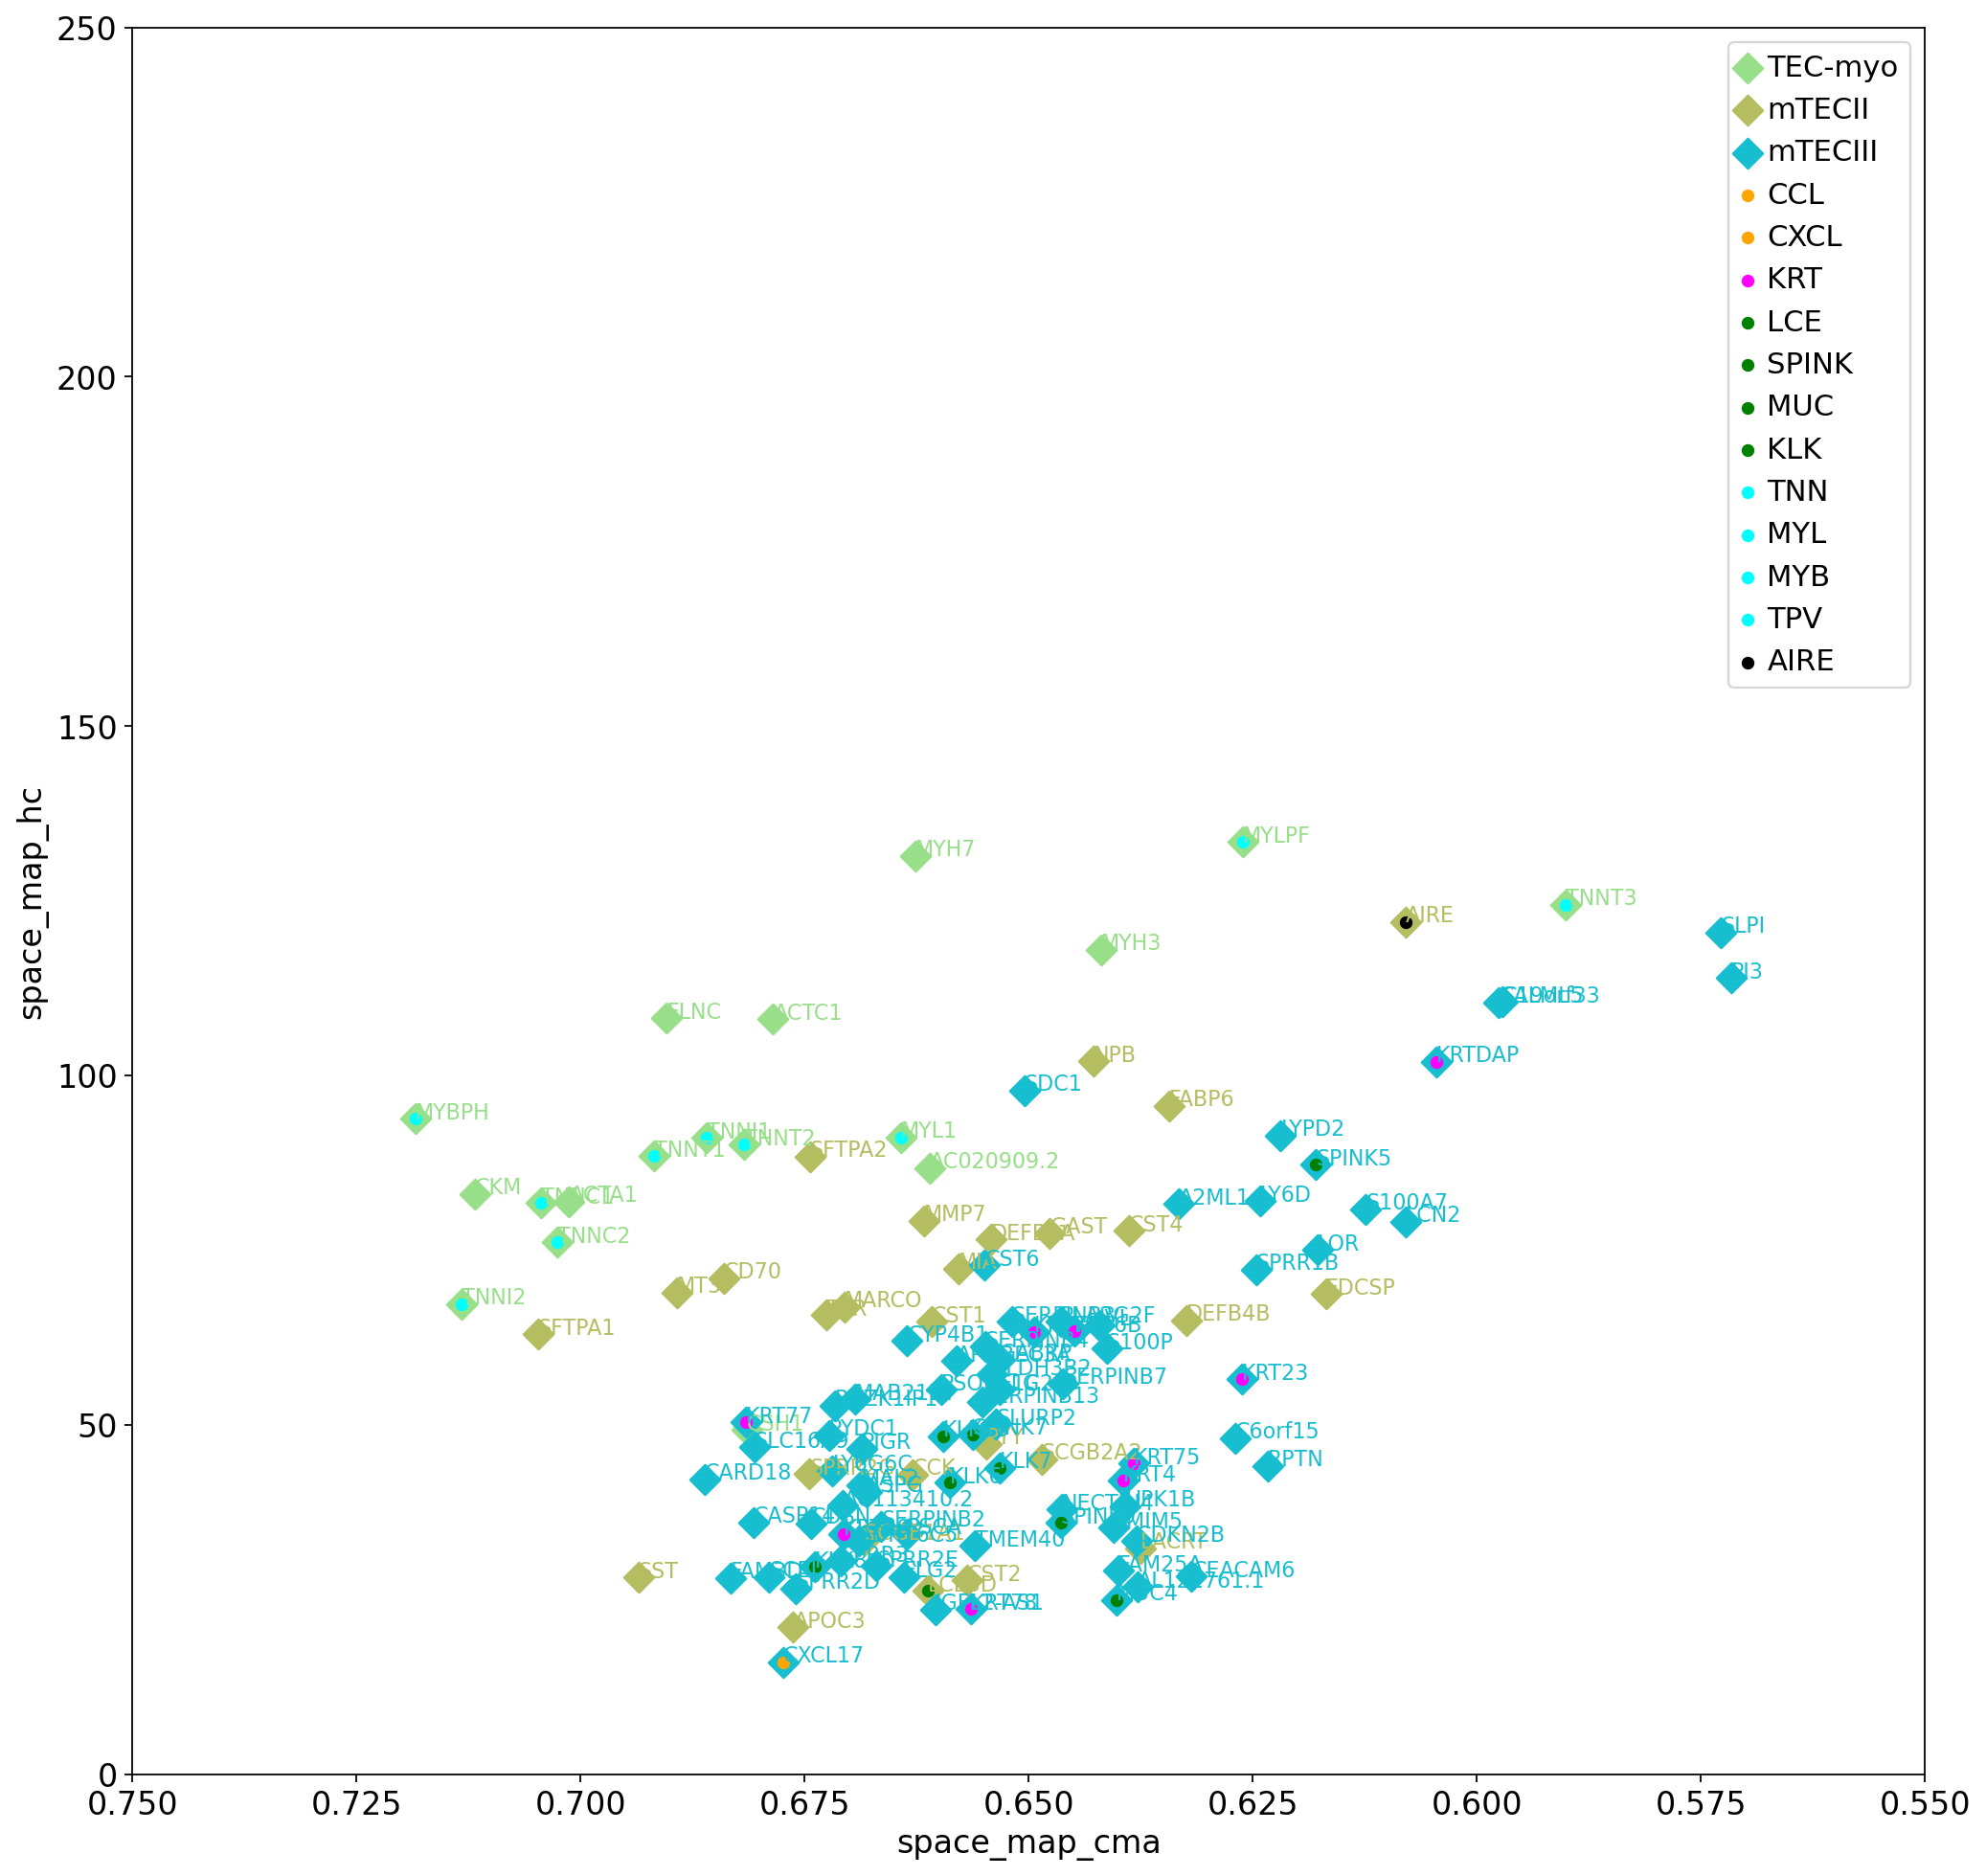

In [132]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=[15,15],fontsize=15)
cmap = plt.get_cmap('tab20')
cell_spots = {}
for key in marker_dict_1.keys():
    df[key+'_unique'] = df.index.isin(marker_dict_1[key])

lengths = {key: len(value) for key, value in marker_dict_1.items()}
print(lengths)
total_sum = sum(lengths.values())
print(total_sum)
flattened_values = [item for sublist in marker_dict_1.values() for item in sublist]
# flattened_values
df_sg = df[df.index.isin(flattened_values)]

colors = sns.color_palette('tab10', 20)
# cmap = ListedColormap(colors)

for idx, key in enumerate(marker_dict_1.keys()):
    if 'TEC' in key:
        plt.scatter(df_sg[df_sg[key + '_unique']]['space_map_cma'], df_sg[df_sg[key + '_unique']]['space_map_hc'], c=color_dict[key], label=key, s=100,marker="D")
        filtered_df = df_sg[df_sg[key + '_unique']]
        for _, row in filtered_df.iterrows():
            plt.annotate(
                str(row.name),  # Using the row's index as the annotation
                (row['space_map_cma'], row['space_map_hc']), 
                fontname='Arial', 
                fontsize=10, 
                color=color_dict[key]
            )
# #     if 'TEC' not in key:
#         plt.scatter(df_sg[df_sg[key + '_unique']]['space_map_cma'], df_sg[df_sg[key + '_unique']]['space_map_hc'],  c=[colors[idx]], label=key, s=100,marker="D")
#         filtered_df = df_sg[df_sg[key + '_unique']]
#         for _, row in filtered_df.iterrows():
#             plt.annotate(
#                 str(row.name),  # Using the row's index as the annotation
#                 (row['space_map_cma'], row['space_map_hc']), 
#                 fontname='Arial', 
#                 fontsize=10, 
#                 color=colors[idx]
#             )


# Define strings to search for and corresponding colors
search_strings = ['CCL', 'CXCL', 'KRT', 'LCE', 'SPINK','MUC', 'KLK','TNN','MYL','MYB','TPV','AIRE',]
colors = ['orange', 'orange', 'magenta','green', 'green', 'green','green','cyan','cyan','cyan','cyan','black']

# Define strings to search for and corresponding colors
# search_strings = ['KRT','IVL']
# colors = ['green','magenta']

# Use a loop to match partial strings, plot scatter points, and add annotations
for search_string, color in zip(search_strings, colors):
    annotate_matching_positions(df_sg,search_string, color,anno=False)

        
plt.grid(False)

# add axis labels
plt.xlabel('space_map_cma')
plt.ylabel('space_map_hc')

plt.legend()
plt.gca().invert_xaxis()

# Set axis limits
plt.xlim(0.75, 0.55) # Since you're inverting the x-axis, the limits are given in reverse order
plt.ylim(0, 250)

plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_CMA_association_genes_names.pdf')
plt.show()


<AxesSubplot:ylabel='Frequency'>

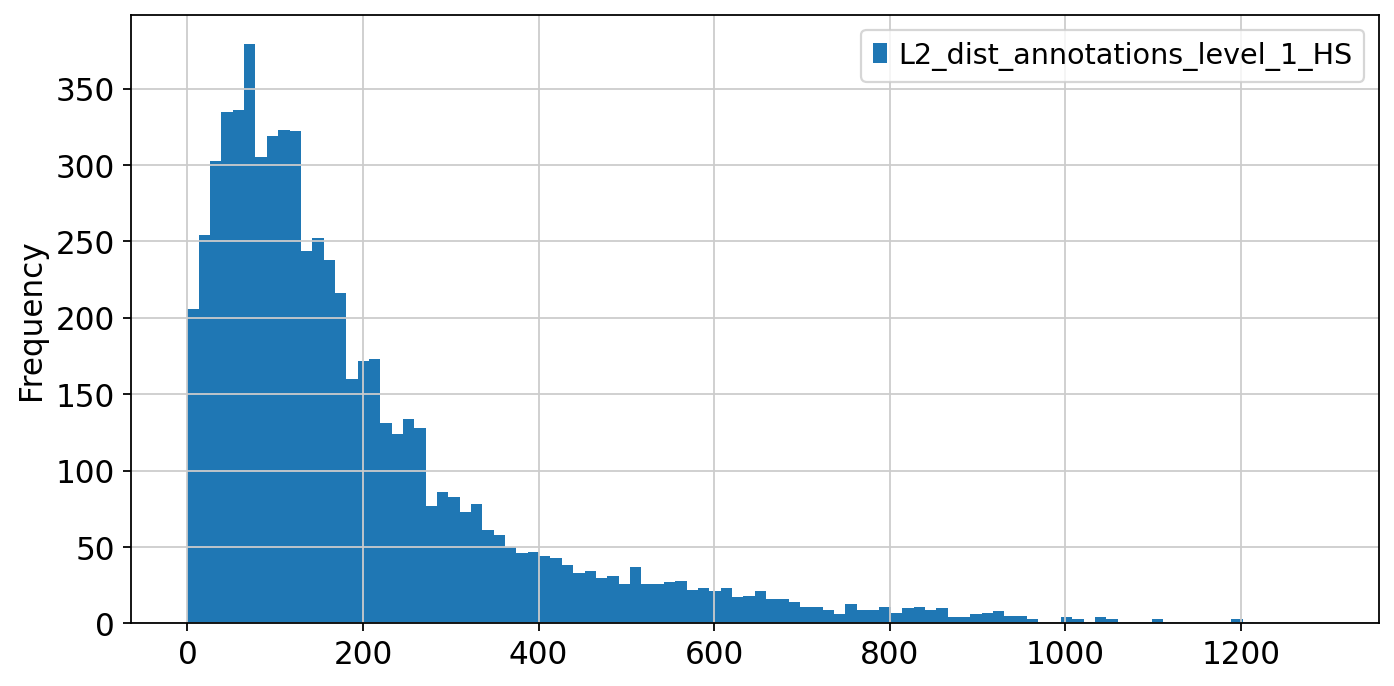

In [576]:
# plot HC distance in the medulla 
sc.set_figure_params(figsize=[10,5])
pd.DataFrame(adata_scvi[adata_scvi.obs.annotations_level_0=='Medulla'].obs['L2_dist_annotations_level_1_HS']*2).plot.hist(bins=100)
plt.savefig('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/figures/HC_hist_medulla.pdf')


In [186]:
adata_tec_paed_med

AnnData object with n_obs × n_vars = 6945 × 36751
    obs: 'age_group', 'age_numeric', 'annotation_level_0', 'annotation_level_1', 'annotation_level_2', 'annotation_level_3', 'backup_barcode', 'barcode_sequence', 'batch', 'bh_pval', 'c_call_VDJ', 'c_call_VDJ_main', 'c_call_VJ', 'c_call_VJ_main', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'c_call_gdT_VDJ', 'c_call_gdT_VJ', 'cc_phase', 'chain_status', 'chemistry', 'chemistry_simple', 'cite_w_protein', 'clone_id', 'clone_id_by_size', 'cluster_scrublet_score', 'ctp_pred', 'ctp_pred_prob', 'ctp_pred_uncertain', 'd_call_VDJ', 'd_call_VDJ_main', 'd_call_abT_VDJ', 'd_call_abT_VDJ_main', 'donor', 'doublet_score', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'enrichment', 'enzyme', 'g2m_Score', 'good_qc_cluster_mito20', 'has_contig', 'isotype', 'isotype_status', 'j_call_VDJ', 'j_call_VDJ_main', 'j_call_VJ', 'j_call_VJ_main', 'j_call_abT_VDJ', 'j_call_abT_VDJ_main', 'j_call_abT_VJ', 'j_call_abT_VJ_main', 'j_call_gdT_VDJ', 'j_call_gdT_VDJ_main', '

## 